# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

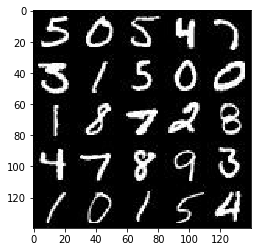

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

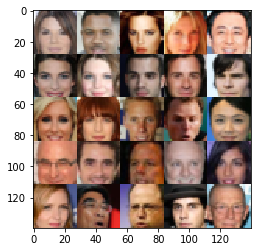

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images=tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_data=tf.placeholder(tf.float32, (None, z_dim))
    lr=tf.placeholder(tf.float32)
    return input_images, z_data, lr

def relu(x):
    return tf.maximum(x, 0.0)

def lrelu(x):
    return tf.maximum(x, tf.multiply(x, 0.2))


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    k=4
    with tf.variable_scope("discriminator", reuse=reuse):
        # 28x28x3
        x=tf.layers.conv2d(images, filters=64, kernel_size=k, strides=2, padding='same')
        x=lrelu(x)
#        x=tf.layers.dropout(x, rate=0.3, training=True)
        
        # 14x14x64
        x=tf.layers.conv2d(x, filters=128, kernel_size=k, strides=2, padding='same')
        x=tf.layers.batch_normalization(x, training=True)
        x=lrelu(x)
 #       x=tf.layers.dropout(x, rate=0.3, training=True)
        
        # 7x7x128
        x=tf.layers.conv2d(x, filters=256, kernel_size=k, strides=2, padding='same')
        x=tf.layers.batch_normalization(x, training=True)
        x=lrelu(x)
  #      x=tf.layers.dropout(x, rate=0.3, training=True)
#        x=tf.reshape(x, (-1, 7*7*128))
        # 4x4x256
        x=tf.reshape(x, (-1, 4*4*256))
#         x=tf.layers.dense(x, 256, activation=relu, kernel_initializer=tf.random_normal_initializer(stddev=0.1))
        logits=tf.layers.dense(x, 1, activation=None)
        out=tf.sigmoid(logits)
    
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    k = 4
    with tf.variable_scope("generator", reuse=not is_train):
        x=tf.layers.dense(z, 4*4*512)
#        x=tf.layers.dropout(x, rate=0.3, training=is_train)        
        x=tf.reshape(x, (-1, 4, 4, 512))
        x=tf.layers.batch_normalization(x, training=is_train)
        x=lrelu(x)
#        x = tf.image.resize_images(x, size=[7, 7])
#        y1=tf.maximum(bn1, 0.2*bn1)
        
    # strides 1, padding valid 4 -> 7
        # 4 x 4 x 512
        x=tf.layers.conv2d_transpose(x, filters=256, kernel_size=k, strides=1, padding='valid')
        x=tf.layers.batch_normalization(x, training=is_train)
        x=lrelu(x)
        
        # 7 x 7 x 256
        x=tf.layers.conv2d_transpose(x, filters=128, kernel_size=k, strides=2, padding='same')
#        x=tf.layers.batch_normalization(x, training=is_train)
        x=lrelu(x)
        
        # 14 x 14 x 128
        x=tf.layers.conv2d_transpose(x, filters=out_channel_dim, kernel_size=k, strides=2, padding='same')
#        x=relu(x)
                
        # 28 x28 x out_channel_dim
        return tf.tanh(x)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    input_fake = generator(input_z, out_channel_dim, True)
    d_labels_real, d_logits_real = discriminator(input_real, False)
    d_labels_fake, d_logits_fake = discriminator(input_fake, True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=0.85*tf.ones_like(d_labels_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_labels_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_labels_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import pickle as pkl


def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    num_channels = data_shape[-1]
    print(num_channels)
    batch_real = None
    samples, losses = [], []
    steps = 0

    print(data_shape)
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], num_channels, z_dim)
    
    print(input_real)
    
    d_loss, g_loss = model_loss(input_real, input_z, num_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_real in get_batches(batch_size):
                steps += 1

                # Rescale to -1,1
                batch_real = batch_real * 2.0

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_real, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_real, input_z: batch_z, lr: learning_rate})
                
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, num_channels, data_image_mode)
            
                if steps % 50:
                    train_loss_d = d_loss.eval({input_real: batch_real, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))

            train_loss_d = d_loss.eval({input_real: batch_real, input_z: batch_z})
            train_loss_g = g_loss.eval({input_z: batch_z})
                    
            print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                  "Discriminator Loss: {:.4f}...".format(train_loss_d),
                  "Generator Loss: {:.4f}".format(train_loss_g))
            


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

1
(60000, 28, 28, 1)
Tensor("Placeholder:0", shape=(?, 28, 28, 1), dtype=float32)
Discriminator Loss: 4.3019... Generator Loss: 0.0302
Discriminator Loss: 3.7833... Generator Loss: 0.0530
Discriminator Loss: 3.0020... Generator Loss: 0.1421
Discriminator Loss: 3.4294... Generator Loss: 0.0745
Discriminator Loss: 2.7607... Generator Loss: 0.1934
Discriminator Loss: 2.1711... Generator Loss: 0.2944
Discriminator Loss: 2.6325... Generator Loss: 0.1756
Discriminator Loss: 2.3958... Generator Loss: 0.4129
Discriminator Loss: 3.2052... Generator Loss: 0.0969
Discriminator Loss: 2.2509... Generator Loss: 1.0652
Discriminator Loss: 3.4492... Generator Loss: 0.0628
Discriminator Loss: 2.2782... Generator Loss: 1.2345
Discriminator Loss: 3.0736... Generator Loss: 0.0958
Discriminator Loss: 2.1340... Generator Loss: 1.0073
Discriminator Loss: 2.7158... Generator Loss: 0.1359
Discriminator Loss: 1.7898... Generator Loss: 1.3605
Discriminator Loss: 3.1684... Generator Loss: 0.0867
Discriminator Los

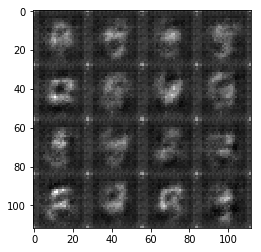

Discriminator Loss: 1.1736... Generator Loss: 1.5244
Discriminator Loss: 1.2142... Generator Loss: 0.6988
Discriminator Loss: 1.1996... Generator Loss: 2.0747
Discriminator Loss: 1.5037... Generator Loss: 0.4609
Discriminator Loss: 1.4083... Generator Loss: 2.2411
Discriminator Loss: 1.3509... Generator Loss: 0.5561
Discriminator Loss: 1.2534... Generator Loss: 1.8406
Discriminator Loss: 1.2385... Generator Loss: 0.6834
Discriminator Loss: 1.1174... Generator Loss: 1.8562
Discriminator Loss: 1.1887... Generator Loss: 0.7565
Discriminator Loss: 1.0780... Generator Loss: 1.5513
Discriminator Loss: 1.0682... Generator Loss: 0.8958
Discriminator Loss: 1.1093... Generator Loss: 1.7980
Discriminator Loss: 1.4583... Generator Loss: 0.5010
Discriminator Loss: 1.5634... Generator Loss: 2.4237
Discriminator Loss: 1.3760... Generator Loss: 0.5611
Discriminator Loss: 1.1387... Generator Loss: 1.8142
Discriminator Loss: 1.1854... Generator Loss: 0.7179
Discriminator Loss: 1.1019... Generator Loss: 

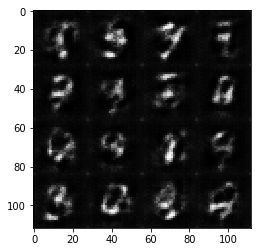

Discriminator Loss: 1.4099... Generator Loss: 2.4146
Discriminator Loss: 1.2789... Generator Loss: 0.6100
Discriminator Loss: 1.1083... Generator Loss: 1.6054
Discriminator Loss: 1.1735... Generator Loss: 0.7377
Discriminator Loss: 1.1698... Generator Loss: 1.4586
Discriminator Loss: 1.1177... Generator Loss: 0.8036
Discriminator Loss: 1.1102... Generator Loss: 1.8916
Discriminator Loss: 1.1389... Generator Loss: 0.7581
Discriminator Loss: 1.1392... Generator Loss: 1.8642
Discriminator Loss: 1.1872... Generator Loss: 0.7174
Discriminator Loss: 1.1270... Generator Loss: 1.9413
Discriminator Loss: 1.3148... Generator Loss: 0.5935
Discriminator Loss: 1.2438... Generator Loss: 2.0119
Discriminator Loss: 1.2546... Generator Loss: 0.6206
Discriminator Loss: 1.1160... Generator Loss: 1.9979
Discriminator Loss: 1.2255... Generator Loss: 0.6650
Discriminator Loss: 1.1338... Generator Loss: 2.0284
Discriminator Loss: 1.2522... Generator Loss: 0.6557
Discriminator Loss: 1.1536... Generator Loss: 

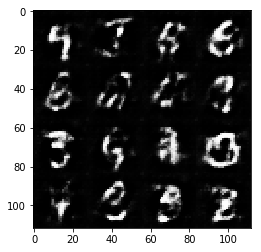

Discriminator Loss: 1.1960... Generator Loss: 0.7347
Discriminator Loss: 1.0339... Generator Loss: 1.5999
Discriminator Loss: 1.0996... Generator Loss: 0.8209
Discriminator Loss: 0.9883... Generator Loss: 1.3607
Discriminator Loss: 1.0605... Generator Loss: 0.8700
Discriminator Loss: 0.9609... Generator Loss: 1.5951
Discriminator Loss: 1.1600... Generator Loss: 0.7493
Discriminator Loss: 1.0166... Generator Loss: 1.7399
Discriminator Loss: 1.0995... Generator Loss: 0.8032
Discriminator Loss: 0.9712... Generator Loss: 1.3976
Discriminator Loss: 1.1116... Generator Loss: 0.8281
Discriminator Loss: 1.0818... Generator Loss: 1.3941
Discriminator Loss: 1.0292... Generator Loss: 0.8850
Discriminator Loss: 1.0062... Generator Loss: 1.5531
Discriminator Loss: 1.1580... Generator Loss: 0.7460
Discriminator Loss: 0.9766... Generator Loss: 1.7367
Discriminator Loss: 1.0730... Generator Loss: 0.8395
Discriminator Loss: 1.1001... Generator Loss: 1.9633
Discriminator Loss: 1.2940... Generator Loss: 

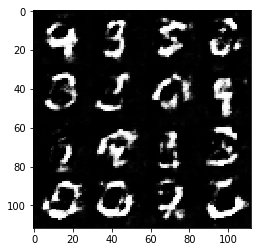

Discriminator Loss: 1.0561... Generator Loss: 0.8945
Discriminator Loss: 0.9471... Generator Loss: 1.3796
Discriminator Loss: 1.0174... Generator Loss: 0.9171
Discriminator Loss: 0.9648... Generator Loss: 1.2172
Discriminator Loss: 1.0607... Generator Loss: 1.0927
Discriminator Loss: 0.9856... Generator Loss: 1.0176
Discriminator Loss: 0.9082... Generator Loss: 1.3160
Discriminator Loss: 1.2118... Generator Loss: 0.6711
Discriminator Loss: 1.0894... Generator Loss: 1.9118
Discriminator Loss: 1.2895... Generator Loss: 0.6018
Discriminator Loss: 1.1623... Generator Loss: 2.2069
Discriminator Loss: 1.3705... Generator Loss: 0.5751
Discriminator Loss: 1.1650... Generator Loss: 1.8899
Discriminator Loss: 1.1802... Generator Loss: 0.7174
Discriminator Loss: 0.9801... Generator Loss: 1.5357
Discriminator Loss: 1.1019... Generator Loss: 0.8452
Discriminator Loss: 1.0174... Generator Loss: 1.4219
Discriminator Loss: 1.1518... Generator Loss: 0.7575
Discriminator Loss: 1.0693... Generator Loss: 

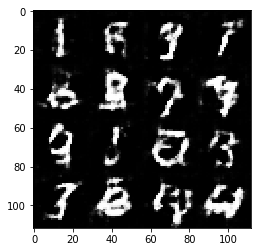

Discriminator Loss: 1.2287... Generator Loss: 1.8415
Discriminator Loss: 1.0980... Generator Loss: 0.8363
Discriminator Loss: 1.2084... Generator Loss: 0.8127
Discriminator Loss: 1.1277... Generator Loss: 1.0436
Discriminator Loss: 1.1302... Generator Loss: 0.9367
Discriminator Loss: 1.0332... Generator Loss: 1.0867
Discriminator Loss: 1.0403... Generator Loss: 1.1254
Discriminator Loss: 1.1598... Generator Loss: 0.7864
Discriminator Loss: 0.9860... Generator Loss: 1.3632
Discriminator Loss: 1.1192... Generator Loss: 0.7633
Discriminator Loss: 1.0970... Generator Loss: 1.6195
Discriminator Loss: 0.9396... Generator Loss: 1.0412
Discriminator Loss: 1.0129... Generator Loss: 1.0914
Discriminator Loss: 0.9654... Generator Loss: 1.2574
Discriminator Loss: 0.9694... Generator Loss: 1.0307
Discriminator Loss: 1.0812... Generator Loss: 1.0429
Discriminator Loss: 1.0770... Generator Loss: 0.8869
Discriminator Loss: 1.1516... Generator Loss: 0.9129
Discriminator Loss: 1.0677... Generator Loss: 

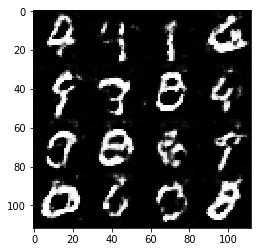

Discriminator Loss: 1.0496... Generator Loss: 1.2055
Discriminator Loss: 1.0989... Generator Loss: 1.0078
Discriminator Loss: 1.0445... Generator Loss: 1.1403
Discriminator Loss: 1.0638... Generator Loss: 0.8673
Discriminator Loss: 1.0753... Generator Loss: 1.1833
Discriminator Loss: 1.1711... Generator Loss: 0.7710
Discriminator Loss: 1.1423... Generator Loss: 1.3211
Discriminator Loss: 1.3598... Generator Loss: 0.5623
Discriminator Loss: 1.2288... Generator Loss: 1.8961
Discriminator Loss: 1.4290... Generator Loss: 0.5061
Discriminator Loss: 1.1789... Generator Loss: 1.6199
Discriminator Loss: 1.3588... Generator Loss: 0.5546
Discriminator Loss: 1.1506... Generator Loss: 1.7904
Discriminator Loss: 1.2732... Generator Loss: 0.6278
Discriminator Loss: 1.1648... Generator Loss: 1.5400
Discriminator Loss: 1.4132... Generator Loss: 0.5168
Discriminator Loss: 1.1770... Generator Loss: 1.7509
Discriminator Loss: 1.2421... Generator Loss: 0.6316
Discriminator Loss: 1.1101... Generator Loss: 

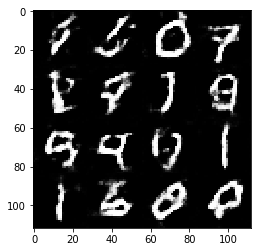

Discriminator Loss: 0.9539... Generator Loss: 1.4312
Discriminator Loss: 1.2067... Generator Loss: 0.6876
Discriminator Loss: 1.0492... Generator Loss: 1.4160
Discriminator Loss: 1.1856... Generator Loss: 0.6941
Discriminator Loss: 1.3075... Generator Loss: 2.0746
Discriminator Loss: 1.2230... Generator Loss: 0.7091
Discriminator Loss: 0.9905... Generator Loss: 1.4367
Discriminator Loss: 1.1140... Generator Loss: 0.8611
Discriminator Loss: 1.1122... Generator Loss: 1.0173
Discriminator Loss: 1.0572... Generator Loss: 1.1671
Discriminator Loss: 1.1930... Generator Loss: 0.7157
Discriminator Loss: 1.0903... Generator Loss: 1.5795
Discriminator Loss: 1.1253... Generator Loss: 0.8064
Discriminator Loss: 1.1814... Generator Loss: 1.0302
Discriminator Loss: 1.0116... Generator Loss: 1.3914
Discriminator Loss: 1.3400... Generator Loss: 0.6168
Discriminator Loss: 1.2229... Generator Loss: 1.9019
Discriminator Loss: 1.3360... Generator Loss: 0.5912
Discriminator Loss: 1.1904... Generator Loss: 

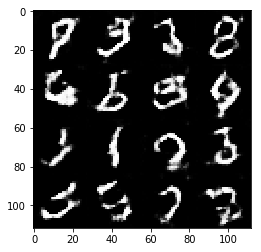

Discriminator Loss: 1.3420... Generator Loss: 0.5805
Discriminator Loss: 1.1290... Generator Loss: 1.1566
Discriminator Loss: 1.0595... Generator Loss: 0.9776
Discriminator Loss: 1.0988... Generator Loss: 0.9712
Discriminator Loss: 1.0377... Generator Loss: 1.1104
Discriminator Loss: 1.3446... Generator Loss: 0.5951
Discriminator Loss: 1.3368... Generator Loss: 2.5164
Discriminator Loss: 1.6280... Generator Loss: 0.4193
Discriminator Loss: 1.2702... Generator Loss: 2.0288
Discriminator Loss: 1.3384... Generator Loss: 0.6241
Discriminator Loss: 1.0923... Generator Loss: 1.5175
Discriminator Loss: 1.0448... Generator Loss: 1.0010
Discriminator Loss: 1.2130... Generator Loss: 0.8027
Discriminator Loss: 1.0712... Generator Loss: 1.4613
Discriminator Loss: 1.1407... Generator Loss: 0.7872
Discriminator Loss: 1.0851... Generator Loss: 1.2150
Discriminator Loss: 1.2609... Generator Loss: 0.6642
Discriminator Loss: 1.1474... Generator Loss: 1.7432
Discriminator Loss: 1.2693... Generator Loss: 

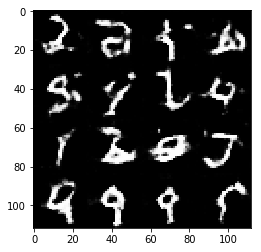

Discriminator Loss: 1.0539... Generator Loss: 1.1779
Discriminator Loss: 1.1964... Generator Loss: 0.7720
Discriminator Loss: 1.1325... Generator Loss: 1.3818
Discriminator Loss: 1.2478... Generator Loss: 0.6976
Discriminator Loss: 1.0611... Generator Loss: 1.6973
Discriminator Loss: 1.1683... Generator Loss: 0.7558
Discriminator Loss: 1.0965... Generator Loss: 1.2960
Discriminator Loss: 1.2743... Generator Loss: 0.6529
Discriminator Loss: 1.0438... Generator Loss: 1.3136
Discriminator Loss: 1.0486... Generator Loss: 0.9265
Discriminator Loss: 1.0627... Generator Loss: 1.1526
Discriminator Loss: 1.0727... Generator Loss: 0.9042
Discriminator Loss: 1.0019... Generator Loss: 1.2926
Discriminator Loss: 1.2153... Generator Loss: 0.6639
Discriminator Loss: 1.2322... Generator Loss: 1.8293
Discriminator Loss: 1.3939... Generator Loss: 0.5133
Discriminator Loss: 1.2097... Generator Loss: 1.9884
Discriminator Loss: 1.2139... Generator Loss: 0.6720
Discriminator Loss: 1.0827... Generator Loss: 

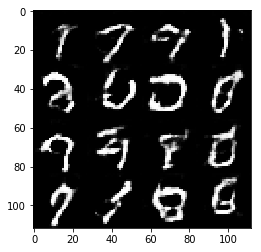

Discriminator Loss: 1.9622... Generator Loss: 2.6786
Discriminator Loss: 1.4334... Generator Loss: 0.5904
Discriminator Loss: 1.5971... Generator Loss: 2.1491
Discriminator Loss: 1.9649... Generator Loss: 0.2908
Discriminator Loss: 1.7221... Generator Loss: 2.2916
Discriminator Loss: 1.5324... Generator Loss: 0.4854
Discriminator Loss: 1.2206... Generator Loss: 1.6260
Discriminator Loss: 1.0637... Generator Loss: 0.8955
Discriminator Loss: 1.0177... Generator Loss: 1.3077
Discriminator Loss: 1.0821... Generator Loss: 0.9661
Discriminator Loss: 1.1161... Generator Loss: 0.9999
Discriminator Loss: 1.1334... Generator Loss: 0.9662
Discriminator Loss: 1.1419... Generator Loss: 0.8408
Discriminator Loss: 1.0048... Generator Loss: 1.2672
Discriminator Loss: 1.0009... Generator Loss: 1.0092
Discriminator Loss: 1.0648... Generator Loss: 0.9855
Discriminator Loss: 1.0555... Generator Loss: 1.0220
Discriminator Loss: 0.9725... Generator Loss: 1.3191
Discriminator Loss: 1.0805... Generator Loss: 

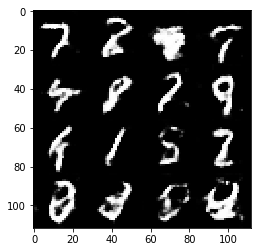

Discriminator Loss: 1.0167... Generator Loss: 0.8880
Discriminator Loss: 0.9895... Generator Loss: 1.5294
Discriminator Loss: 1.0480... Generator Loss: 0.8849
Discriminator Loss: 0.9773... Generator Loss: 0.9648
Discriminator Loss: 0.9828... Generator Loss: 1.4069
Discriminator Loss: 1.2743... Generator Loss: 0.6212
Discriminator Loss: 1.0686... Generator Loss: 2.0170
Discriminator Loss: 1.1760... Generator Loss: 0.7044
Discriminator Loss: 1.2900... Generator Loss: 2.0293
Discriminator Loss: 1.4933... Generator Loss: 0.5044
Discriminator Loss: 1.0608... Generator Loss: 1.8214
Discriminator Loss: 1.1087... Generator Loss: 0.8027
Discriminator Loss: 0.8493... Generator Loss: 1.5202
Discriminator Loss: 1.0479... Generator Loss: 0.9023
Discriminator Loss: 0.9153... Generator Loss: 1.5298
Discriminator Loss: 1.1238... Generator Loss: 0.7555
Discriminator Loss: 0.9501... Generator Loss: 1.4257
Discriminator Loss: 0.8231... Generator Loss: 1.2161
Discriminator Loss: 0.9137... Generator Loss: 

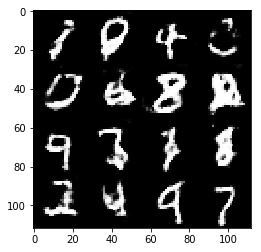

Discriminator Loss: 1.0889... Generator Loss: 0.7913
Discriminator Loss: 0.8977... Generator Loss: 1.5012
Discriminator Loss: 1.1091... Generator Loss: 0.7750
Discriminator Loss: 0.8841... Generator Loss: 1.3244
Discriminator Loss: 0.9643... Generator Loss: 1.0063
Discriminator Loss: 0.9893... Generator Loss: 1.0857
Discriminator Loss: 0.8788... Generator Loss: 1.3423
Discriminator Loss: 1.0828... Generator Loss: 0.8149
Discriminator Loss: 0.8791... Generator Loss: 1.6420
Discriminator Loss: 1.1551... Generator Loss: 0.7354
Discriminator Loss: 0.9451... Generator Loss: 1.2622
Discriminator Loss: 1.0633... Generator Loss: 0.8351
Discriminator Loss: 0.8734... Generator Loss: 1.5763
Discriminator Loss: 1.1560... Generator Loss: 0.7270
Discriminator Loss: 1.1960... Generator Loss: 2.4584
Discriminator Loss: 1.3201... Generator Loss: 0.5951
Discriminator Loss: 1.1069... Generator Loss: 1.3306
Discriminator Loss: 1.2489... Generator Loss: 0.6194
Discriminator Loss: 0.9916... Generator Loss: 

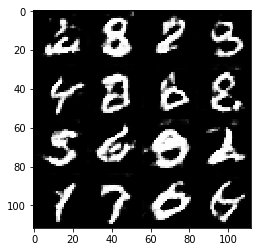

Discriminator Loss: 0.7565... Generator Loss: 1.5114
Discriminator Loss: 0.9648... Generator Loss: 0.9514
Discriminator Loss: 0.9221... Generator Loss: 1.3223
Discriminator Loss: 0.9436... Generator Loss: 1.0427
Discriminator Loss: 0.9016... Generator Loss: 1.3057
Discriminator Loss: 0.9370... Generator Loss: 1.0660
Discriminator Loss: 0.8767... Generator Loss: 1.4009
Discriminator Loss: 1.2573... Generator Loss: 0.6292
Discriminator Loss: 1.0782... Generator Loss: 1.6517
Discriminator Loss: 1.2064... Generator Loss: 0.6644
Discriminator Loss: 1.0797... Generator Loss: 2.0185
Discriminator Loss: 1.5208... Generator Loss: 0.4707
Discriminator Loss: 1.4277... Generator Loss: 2.0696
Discriminator Loss: 1.2435... Generator Loss: 0.7629
Discriminator Loss: 1.5083... Generator Loss: 2.5062
Discriminator Loss: 2.1707... Generator Loss: 0.2658
Discriminator Loss: 1.1294... Generator Loss: 2.8219
Discriminator Loss: 1.1034... Generator Loss: 0.8491
Discriminator Loss: 0.9073... Generator Loss: 

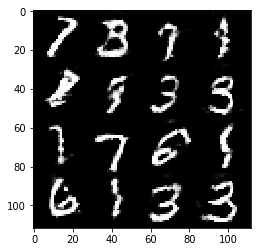

Discriminator Loss: 1.0785... Generator Loss: 2.2993
Discriminator Loss: 1.1319... Generator Loss: 0.7478
Discriminator Loss: 1.0305... Generator Loss: 1.4189
Discriminator Loss: 1.0257... Generator Loss: 0.8675
Discriminator Loss: 0.8338... Generator Loss: 1.6054
Discriminator Loss: 0.8865... Generator Loss: 1.1030
Discriminator Loss: 0.9565... Generator Loss: 1.1029
Discriminator Loss: 1.0558... Generator Loss: 0.8299
Discriminator Loss: 1.0658... Generator Loss: 2.0283
Discriminator Loss: 1.4653... Generator Loss: 0.4938
Discriminator Loss: 1.7327... Generator Loss: 2.4018
Discriminator Loss: 1.1929... Generator Loss: 0.6982
Discriminator Loss: 1.4867... Generator Loss: 2.1582
Discriminator Loss: 2.4043... Generator Loss: 0.1957
Discriminator Loss: 2.6670... Generator Loss: 3.7678
Discriminator Loss: 1.3710... Generator Loss: 0.5921
Discriminator Loss: 0.9875... Generator Loss: 1.1824
Discriminator Loss: 1.0368... Generator Loss: 1.0388
Discriminator Loss: 1.0319... Generator Loss: 

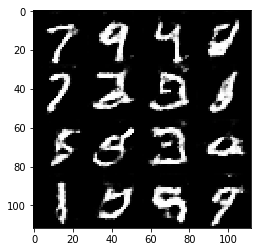

Discriminator Loss: 0.9052... Generator Loss: 1.2001
Discriminator Loss: 0.9757... Generator Loss: 0.9705
Discriminator Loss: 0.8857... Generator Loss: 1.3093
Discriminator Loss: 1.0385... Generator Loss: 0.8581
Discriminator Loss: 0.8509... Generator Loss: 1.6786
Discriminator Loss: 1.4473... Generator Loss: 0.5082
Discriminator Loss: 1.1174... Generator Loss: 2.1035
Discriminator Loss: 1.3281... Generator Loss: 0.5851
Discriminator Loss: 1.4709... Generator Loss: 2.7356
Discriminator Loss: 2.0568... Generator Loss: 0.3048
Discriminator Loss: 2.9117... Generator Loss: 4.0790
Discriminator Loss: 2.4102... Generator Loss: 0.2487
Discriminator Loss: 1.2591... Generator Loss: 2.5976
Discriminator Loss: 1.2283... Generator Loss: 0.8024
Discriminator Loss: 0.8851... Generator Loss: 1.4003
Discriminator Loss: 0.9457... Generator Loss: 1.0627
Discriminator Loss: 0.9458... Generator Loss: 1.2236
Discriminator Loss: 0.8906... Generator Loss: 1.2336
Discriminator Loss: 0.8876... Generator Loss: 

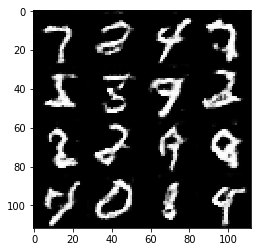

Discriminator Loss: 2.7227... Generator Loss: 0.1464
Discriminator Loss: 1.2130... Generator Loss: 2.2055
Discriminator Loss: 1.1023... Generator Loss: 0.8331
Discriminator Loss: 0.9959... Generator Loss: 1.2795
Discriminator Loss: 1.2146... Generator Loss: 0.6756
Discriminator Loss: 0.9117... Generator Loss: 1.6659
Discriminator Loss: 1.0369... Generator Loss: 0.9307
Discriminator Loss: 0.8728... Generator Loss: 1.2973
Discriminator Loss: 1.0127... Generator Loss: 0.9505
Discriminator Loss: 0.9235... Generator Loss: 1.2340
Discriminator Loss: 0.8171... Generator Loss: 1.3874
Discriminator Loss: 0.9381... Generator Loss: 1.0007
Discriminator Loss: 0.9198... Generator Loss: 1.0883
Discriminator Loss: 0.8577... Generator Loss: 1.2575
Discriminator Loss: 0.8615... Generator Loss: 1.4366
Discriminator Loss: 1.2702... Generator Loss: 0.6181
Discriminator Loss: 0.8737... Generator Loss: 1.6201
Discriminator Loss: 1.1626... Generator Loss: 0.7114
Discriminator Loss: 1.0823... Generator Loss: 

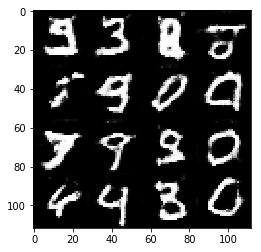

Discriminator Loss: 0.9903... Generator Loss: 0.9406
Discriminator Loss: 0.7404... Generator Loss: 1.7825
Discriminator Loss: 0.9833... Generator Loss: 0.9878
Discriminator Loss: 0.8405... Generator Loss: 1.7332
Discriminator Loss: 1.0113... Generator Loss: 0.9260
Discriminator Loss: 1.0961... Generator Loss: 1.7357
Discriminator Loss: 1.6111... Generator Loss: 0.4399
Discriminator Loss: 1.7482... Generator Loss: 2.7613
Discriminator Loss: 1.1970... Generator Loss: 0.7537
Discriminator Loss: 1.3871... Generator Loss: 2.1510
Discriminator Loss: 2.4331... Generator Loss: 0.1964
Discriminator Loss: 2.5316... Generator Loss: 4.0707
Discriminator Loss: 1.3405... Generator Loss: 0.6151
Discriminator Loss: 1.1725... Generator Loss: 1.3882
Discriminator Loss: 1.2304... Generator Loss: 0.7022
Discriminator Loss: 1.1261... Generator Loss: 1.4315
Discriminator Loss: 1.2365... Generator Loss: 0.7232
Discriminator Loss: 1.0349... Generator Loss: 1.5300
Discriminator Loss: 1.3506... Generator Loss: 

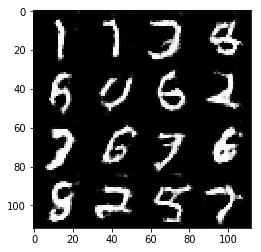

Discriminator Loss: 0.7934... Generator Loss: 1.5063
Discriminator Loss: 1.0731... Generator Loss: 0.8036
Discriminator Loss: 0.8285... Generator Loss: 1.4634
Discriminator Loss: 1.0222... Generator Loss: 0.9012
Discriminator Loss: 0.9821... Generator Loss: 1.0554
Discriminator Loss: 0.8551... Generator Loss: 1.2284
Discriminator Loss: 0.8247... Generator Loss: 1.5496
Discriminator Loss: 0.9605... Generator Loss: 1.0125
Discriminator Loss: 0.8664... Generator Loss: 1.3051
Discriminator Loss: 0.8400... Generator Loss: 1.2844
Discriminator Loss: 0.8425... Generator Loss: 1.2449
Discriminator Loss: 0.8705... Generator Loss: 1.1928
Discriminator Loss: 0.8454... Generator Loss: 1.3831
Discriminator Loss: 1.1745... Generator Loss: 0.7358
Discriminator Loss: 1.0234... Generator Loss: 1.3586
Discriminator Loss: 1.2322... Generator Loss: 0.6408
Discriminator Loss: 1.1118... Generator Loss: 2.2483
Discriminator Loss: 1.5712... Generator Loss: 0.4439
Discriminator Loss: 1.6168... Generator Loss: 

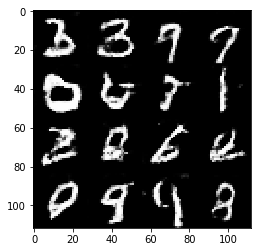

Discriminator Loss: 1.0226... Generator Loss: 1.9737
Discriminator Loss: 1.2214... Generator Loss: 0.6733
Discriminator Loss: 0.9253... Generator Loss: 1.9105
Discriminator Loss: 1.2108... Generator Loss: 0.7513
Discriminator Loss: 0.8785... Generator Loss: 1.3537
Discriminator Loss: 0.9495... Generator Loss: 1.0976
Discriminator Loss: 0.8906... Generator Loss: 1.1498
Discriminator Loss: 0.8473... Generator Loss: 1.2200
Discriminator Loss: 0.9029... Generator Loss: 1.1281
Discriminator Loss: 1.1696... Generator Loss: 0.7262
Discriminator Loss: 0.9289... Generator Loss: 1.5173
Discriminator Loss: 0.9638... Generator Loss: 0.9376
Discriminator Loss: 0.9113... Generator Loss: 1.1261
Discriminator Loss: 0.9039... Generator Loss: 1.1336
Discriminator Loss: 0.8753... Generator Loss: 1.1639
Discriminator Loss: 0.8769... Generator Loss: 1.2107
Discriminator Loss: 0.7503... Generator Loss: 1.5641
Discriminator Loss: 1.0372... Generator Loss: 0.8489
Discriminator Loss: 0.8469... Generator Loss: 

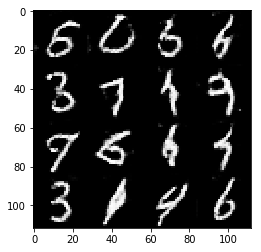

Discriminator Loss: 1.0717... Generator Loss: 0.9361
Discriminator Loss: 0.9789... Generator Loss: 1.7197
Discriminator Loss: 1.4270... Generator Loss: 0.5205
Discriminator Loss: 0.9622... Generator Loss: 1.6141
Discriminator Loss: 0.8571... Generator Loss: 1.3827
Discriminator Loss: 1.0198... Generator Loss: 0.9138
Discriminator Loss: 0.8643... Generator Loss: 1.2567
Discriminator Loss: 0.9110... Generator Loss: 1.0910
Discriminator Loss: 0.9273... Generator Loss: 1.2258
Discriminator Loss: 0.8939... Generator Loss: 1.1587
Discriminator Loss: 0.7544... Generator Loss: 1.6771
Discriminator Loss: 1.0428... Generator Loss: 0.8789
Discriminator Loss: 0.8788... Generator Loss: 2.1393
Discriminator Loss: 0.8161... Generator Loss: 1.3075
Discriminator Loss: 1.2050... Generator Loss: 0.6882
Discriminator Loss: 1.0078... Generator Loss: 1.8612
Discriminator Loss: 0.9361... Generator Loss: 1.0632
Discriminator Loss: 1.3041... Generator Loss: 0.5928
Discriminator Loss: 0.9669... Generator Loss: 

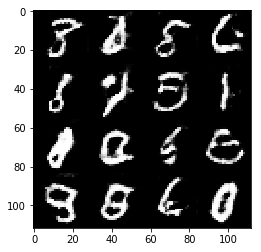

Discriminator Loss: 0.9082... Generator Loss: 1.1146
Discriminator Loss: 0.7664... Generator Loss: 1.6493
Discriminator Loss: 1.5259... Generator Loss: 0.4862
Discriminator Loss: 1.4518... Generator Loss: 3.3484
Discriminator Loss: 2.1665... Generator Loss: 0.2907
Discriminator Loss: 0.9497... Generator Loss: 3.3737
Discriminator Loss: 0.9128... Generator Loss: 1.1837
Discriminator Loss: 1.0251... Generator Loss: 0.8928
Discriminator Loss: 0.8942... Generator Loss: 1.2308
Discriminator Loss: 0.8670... Generator Loss: 1.8537
Discriminator Loss: 1.3110... Generator Loss: 0.6562
Discriminator Loss: 1.3712... Generator Loss: 2.3976
Discriminator Loss: 1.5314... Generator Loss: 0.5039
Discriminator Loss: 1.1709... Generator Loss: 2.0859
Discriminator Loss: 1.2798... Generator Loss: 0.6597
Discriminator Loss: 0.8990... Generator Loss: 1.5446
Discriminator Loss: 0.9156... Generator Loss: 1.1465
Discriminator Loss: 0.9520... Generator Loss: 1.0807
Discriminator Loss: 0.8187... Generator Loss: 

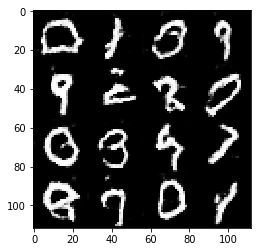

Discriminator Loss: 0.8935... Generator Loss: 1.5814
Discriminator Loss: 0.9529... Generator Loss: 0.9697
Discriminator Loss: 0.7692... Generator Loss: 1.5216
Discriminator Loss: 0.9906... Generator Loss: 1.0129
Discriminator Loss: 0.9867... Generator Loss: 2.2347
Discriminator Loss: 0.9017... Generator Loss: 1.1150
Discriminator Loss: 0.7925... Generator Loss: 1.5188
Discriminator Loss: 1.0671... Generator Loss: 0.8766
Discriminator Loss: 1.3552... Generator Loss: 3.0672
Discriminator Loss: 1.6355... Generator Loss: 0.4831
Discriminator Loss: 2.2728... Generator Loss: 4.3147
Discriminator Loss: 1.9538... Generator Loss: 0.3205
Discriminator Loss: 2.4956... Generator Loss: 3.9767
Discriminator Loss: 1.5186... Generator Loss: 0.5239
Discriminator Loss: 1.2157... Generator Loss: 2.3627
Discriminator Loss: 1.1838... Generator Loss: 0.7488
Discriminator Loss: 0.9794... Generator Loss: 2.0035
Discriminator Loss: 1.0386... Generator Loss: 0.9364
Discriminator Loss: 1.0352... Generator Loss: 

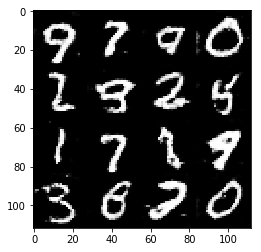

Discriminator Loss: 0.8217... Generator Loss: 2.1568
Discriminator Loss: 1.4473... Generator Loss: 0.5369
Discriminator Loss: 0.9772... Generator Loss: 2.4628
Discriminator Loss: 1.2376... Generator Loss: 0.6891
Discriminator Loss: 0.8749... Generator Loss: 1.9131
Discriminator Loss: 1.0307... Generator Loss: 0.8991
Discriminator Loss: 0.7245... Generator Loss: 2.0439
Discriminator Loss: 1.2540... Generator Loss: 0.6766
Discriminator Loss: 0.9849... Generator Loss: 2.3127
Discriminator Loss: 1.0412... Generator Loss: 0.9919
Discriminator Loss: 0.8403... Generator Loss: 1.3254
Discriminator Loss: 0.8015... Generator Loss: 1.5865
Discriminator Loss: 0.8433... Generator Loss: 1.2156
Discriminator Loss: 0.8312... Generator Loss: 1.2283
Discriminator Loss: 0.7830... Generator Loss: 1.7942
Discriminator Loss: 0.8573... Generator Loss: 1.1910
Discriminator Loss: 0.8261... Generator Loss: 1.2378
Discriminator Loss: 0.7865... Generator Loss: 1.6301
Discriminator Loss: 0.8787... Generator Loss: 

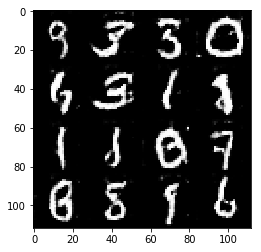

Discriminator Loss: 0.8668... Generator Loss: 1.1090
Discriminator Loss: 0.7462... Generator Loss: 1.5911
Discriminator Loss: 0.7690... Generator Loss: 1.3855
Discriminator Loss: 0.7918... Generator Loss: 1.3239
Discriminator Loss: 0.7637... Generator Loss: 1.7347
Discriminator Loss: 1.1603... Generator Loss: 0.7575
Discriminator Loss: 0.7927... Generator Loss: 2.0221
Discriminator Loss: 1.1528... Generator Loss: 0.7561
Discriminator Loss: 0.7463... Generator Loss: 1.7087
Discriminator Loss: 1.0703... Generator Loss: 0.8724
Discriminator Loss: 0.9714... Generator Loss: 2.2774
Discriminator Loss: 1.3285... Generator Loss: 0.6043
Discriminator Loss: 0.9975... Generator Loss: 2.0082
Discriminator Loss: 1.3217... Generator Loss: 0.6383
Discriminator Loss: 1.1917... Generator Loss: 2.8060
Discriminator Loss: 1.5754... Generator Loss: 0.5203
Discriminator Loss: 1.0576... Generator Loss: 2.6480
Discriminator Loss: 1.2246... Generator Loss: 0.7535
Discriminator Loss: 1.0500... Generator Loss: 

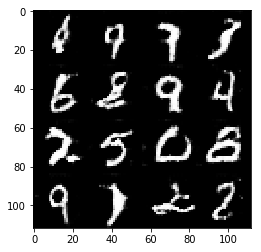

Discriminator Loss: 0.7438... Generator Loss: 1.5065
Discriminator Loss: 1.3313... Generator Loss: 0.6354
Discriminator Loss: 1.1153... Generator Loss: 2.8297
Discriminator Loss: 1.3164... Generator Loss: 0.6724
Discriminator Loss: 0.9686... Generator Loss: 2.6847
Discriminator Loss: 1.1070... Generator Loss: 0.7993
Discriminator Loss: 0.9163... Generator Loss: 1.9726
Discriminator Loss: 0.9404... Generator Loss: 1.0908
Discriminator Loss: 0.8169... Generator Loss: 1.5985
Discriminator Loss: 0.9558... Generator Loss: 1.0154
Discriminator Loss: 0.9096... Generator Loss: 1.0854
Discriminator Loss: 0.7880... Generator Loss: 1.6172
Discriminator Loss: 0.9320... Generator Loss: 0.9957
Discriminator Loss: 0.8692... Generator Loss: 1.2654
Discriminator Loss: 0.8418... Generator Loss: 1.3567
Discriminator Loss: 0.9833... Generator Loss: 0.9402
Discriminator Loss: 0.7873... Generator Loss: 1.4533
Discriminator Loss: 0.7574... Generator Loss: 1.6622
Discriminator Loss: 1.0353... Generator Loss: 

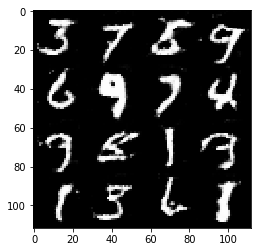

Discriminator Loss: 0.8102... Generator Loss: 1.8595
Discriminator Loss: 0.9507... Generator Loss: 1.0610
Discriminator Loss: 0.7713... Generator Loss: 1.5068
Discriminator Loss: 0.7886... Generator Loss: 1.5369
Discriminator Loss: 0.9578... Generator Loss: 0.9868
Discriminator Loss: 0.9130... Generator Loss: 1.1648
Discriminator Loss: 1.0069... Generator Loss: 0.9109
Discriminator Loss: 0.7016... Generator Loss: 2.0601
Discriminator Loss: 1.1135... Generator Loss: 0.7987
Discriminator Loss: 0.7186... Generator Loss: 2.3672
Discriminator Loss: 1.4569... Generator Loss: 0.5861
Discriminator Loss: 1.2698... Generator Loss: 2.7309
Discriminator Loss: 2.1992... Generator Loss: 0.2817
Discriminator Loss: 3.1767... Generator Loss: 5.4177
Discriminator Loss: 1.1846... Generator Loss: 0.8136
Discriminator Loss: 1.0795... Generator Loss: 1.8078
Discriminator Loss: 1.0575... Generator Loss: 0.8745
Discriminator Loss: 0.9669... Generator Loss: 1.4539
Discriminator Loss: 0.7620... Generator Loss: 

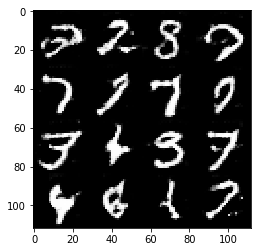

Discriminator Loss: 1.1203... Generator Loss: 0.8087
Discriminator Loss: 0.7641... Generator Loss: 2.0195
Discriminator Loss: 1.0654... Generator Loss: 0.8947
Discriminator Loss: 0.8064... Generator Loss: 2.1753
Discriminator Loss: 1.2704... Generator Loss: 0.6395
Discriminator Loss: 1.0398... Generator Loss: 2.4145
Discriminator Loss: 1.4514... Generator Loss: 0.5417
Discriminator Loss: 0.8066... Generator Loss: 2.1639
Discriminator Loss: 1.1200... Generator Loss: 0.7882
Discriminator Loss: 0.7944... Generator Loss: 1.6292
Discriminator Loss: 1.1054... Generator Loss: 0.8209
Discriminator Loss: 0.8484... Generator Loss: 1.9147
Discriminator Loss: 1.4901... Generator Loss: 0.5019
Discriminator Loss: 0.8798... Generator Loss: 1.3163
Discriminator Loss: 0.9277... Generator Loss: 1.0642
Discriminator Loss: 1.0912... Generator Loss: 2.6786
Discriminator Loss: 1.2050... Generator Loss: 0.7507
Discriminator Loss: 0.9563... Generator Loss: 1.7271
Discriminator Loss: 1.1073... Generator Loss: 

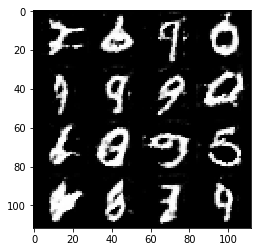

Discriminator Loss: 0.6986... Generator Loss: 2.3141
Discriminator Loss: 1.0701... Generator Loss: 0.8411
Discriminator Loss: 0.8646... Generator Loss: 1.1959
Discriminator Loss: 1.1427... Generator Loss: 0.7793
Discriminator Loss: 0.8133... Generator Loss: 1.3153
Discriminator Loss: 0.7723... Generator Loss: 2.1409
Discriminator Loss: 1.5449... Generator Loss: 0.5240
Discriminator Loss: 1.4239... Generator Loss: 3.0597
Discriminator Loss: 2.0516... Generator Loss: 0.3116
Discriminator Loss: 1.2591... Generator Loss: 3.4299
Discriminator Loss: 0.9063... Generator Loss: 1.1751
Discriminator Loss: 0.8491... Generator Loss: 1.2819
Discriminator Loss: 0.8126... Generator Loss: 1.6721
Discriminator Loss: 1.2287... Generator Loss: 0.6937
Discriminator Loss: 1.0208... Generator Loss: 1.9612
Discriminator Loss: 1.2194... Generator Loss: 0.7057
Discriminator Loss: 0.8574... Generator Loss: 1.9054
Discriminator Loss: 1.4768... Generator Loss: 0.5507
Discriminator Loss: 0.8344... Generator Loss: 

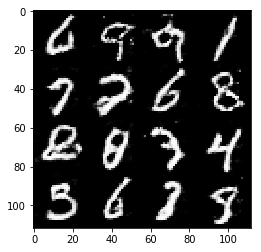

Discriminator Loss: 1.5351... Generator Loss: 2.9149
Discriminator Loss: 1.3290... Generator Loss: 0.6191
Discriminator Loss: 0.9658... Generator Loss: 1.9991
Discriminator Loss: 1.1513... Generator Loss: 0.7891
Discriminator Loss: 0.9794... Generator Loss: 1.4998
Discriminator Loss: 0.9337... Generator Loss: 1.0571
Discriminator Loss: 0.9001... Generator Loss: 1.1879
Discriminator Loss: 0.7983... Generator Loss: 1.5231
Discriminator Loss: 0.8402... Generator Loss: 1.2068
Discriminator Loss: 0.9542... Generator Loss: 1.0266
Discriminator Loss: 0.7925... Generator Loss: 1.6265
Discriminator Loss: 0.9176... Generator Loss: 1.0647
Discriminator Loss: 0.7317... Generator Loss: 1.8072
Discriminator Loss: 0.8748... Generator Loss: 1.1392
Discriminator Loss: 0.8735... Generator Loss: 1.6122
Discriminator Loss: 1.2917... Generator Loss: 0.6752
Discriminator Loss: 0.7421... Generator Loss: 1.8711
Discriminator Loss: 1.1050... Generator Loss: 0.8124
Discriminator Loss: 0.9380... Generator Loss: 

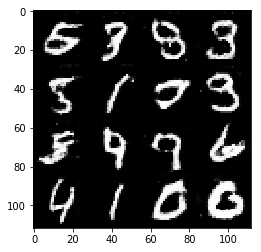

Discriminator Loss: 0.8915... Generator Loss: 1.6192
Discriminator Loss: 0.8430... Generator Loss: 1.5670
Discriminator Loss: 1.6522... Generator Loss: 0.4528
Discriminator Loss: 1.8409... Generator Loss: 4.1855
Discriminator Loss: 1.5167... Generator Loss: 0.6297
Discriminator Loss: 0.8027... Generator Loss: 2.1691
Discriminator Loss: 0.7478... Generator Loss: 1.5206
Discriminator Loss: 0.8655... Generator Loss: 1.2073
Discriminator Loss: 0.8237... Generator Loss: 1.3400
Discriminator Loss: 0.8072... Generator Loss: 1.3562
Discriminator Loss: 1.0616... Generator Loss: 0.8349
Discriminator Loss: 0.7364... Generator Loss: 1.7920
Discriminator Loss: 0.8671... Generator Loss: 1.1755
Discriminator Loss: 0.6880... Generator Loss: 1.8198
Discriminator Loss: 1.0289... Generator Loss: 0.8778
Discriminator Loss: 0.8656... Generator Loss: 1.1936
Discriminator Loss: 0.7640... Generator Loss: 1.5298
Discriminator Loss: 0.8762... Generator Loss: 1.0916
Discriminator Loss: 0.7873... Generator Loss: 

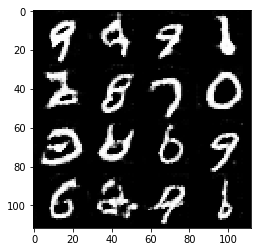

Discriminator Loss: 1.2816... Generator Loss: 0.6715
Discriminator Loss: 0.7560... Generator Loss: 2.2923
Discriminator Loss: 0.9646... Generator Loss: 1.0292
Discriminator Loss: 0.8183... Generator Loss: 1.5832
Discriminator Loss: 0.9532... Generator Loss: 0.9894
Discriminator Loss: 0.9240... Generator Loss: 1.1006
Discriminator Loss: 0.7611... Generator Loss: 2.0375
Discriminator Loss: 1.0233... Generator Loss: 0.9007
Discriminator Loss: 0.7538... Generator Loss: 1.5897
Discriminator Loss: 1.0383... Generator Loss: 0.9264
Discriminator Loss: 0.6809... Generator Loss: 2.0900
Discriminator Loss: 0.7633... Generator Loss: 1.4789
Discriminator Loss: 1.0740... Generator Loss: 0.8315
Discriminator Loss: 0.8636... Generator Loss: 1.3028
Discriminator Loss: 0.9396... Generator Loss: 1.0153
Discriminator Loss: 0.6979... Generator Loss: 1.9971
Discriminator Loss: 1.0671... Generator Loss: 0.8861
Discriminator Loss: 0.9715... Generator Loss: 2.1403
Discriminator Loss: 1.5767... Generator Loss: 

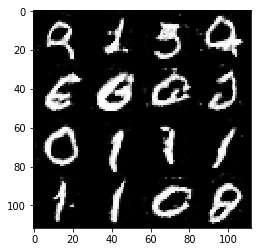

Discriminator Loss: 0.8971... Generator Loss: 1.1283
Discriminator Loss: 0.7952... Generator Loss: 1.3507
Discriminator Loss: 0.8318... Generator Loss: 1.2555
Discriminator Loss: 0.6969... Generator Loss: 1.8773
Discriminator Loss: 1.1366... Generator Loss: 0.8079
Discriminator Loss: 0.7997... Generator Loss: 1.5890
Discriminator Loss: 1.0877... Generator Loss: 0.8507
Discriminator Loss: 0.7054... Generator Loss: 2.4465
Discriminator Loss: 0.9492... Generator Loss: 1.0623
Discriminator Loss: 0.7781... Generator Loss: 2.3724
Discriminator Loss: 1.0305... Generator Loss: 0.9589
Discriminator Loss: 0.7988... Generator Loss: 1.8150
Discriminator Loss: 1.1804... Generator Loss: 0.7700
Discriminator Loss: 0.7289... Generator Loss: 1.6237
Discriminator Loss: 1.2531... Generator Loss: 0.7087
Discriminator Loss: 1.1103... Generator Loss: 2.2499
Discriminator Loss: 1.0348... Generator Loss: 0.8894
Discriminator Loss: 0.7043... Generator Loss: 2.3627
Discriminator Loss: 0.9672... Generator Loss: 

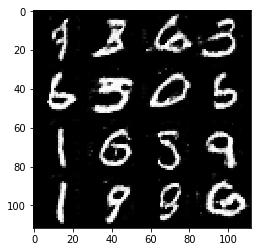

Discriminator Loss: 0.7893... Generator Loss: 1.5743
Discriminator Loss: 0.6872... Generator Loss: 1.6681
Discriminator Loss: 0.7783... Generator Loss: 1.3340
Discriminator Loss: 0.6950... Generator Loss: 1.6355
Discriminator Loss: 0.9059... Generator Loss: 1.0786
Discriminator Loss: 0.7526... Generator Loss: 1.4412
Discriminator Loss: 0.7390... Generator Loss: 2.0066
Discriminator Loss: 0.9096... Generator Loss: 1.1229
Discriminator Loss: 0.8513... Generator Loss: 1.1639
Discriminator Loss: 0.8260... Generator Loss: 1.2745
Discriminator Loss: 0.8172... Generator Loss: 1.3391
Discriminator Loss: 0.7165... Generator Loss: 1.5575
Discriminator Loss: 0.7640... Generator Loss: 1.4315
Discriminator Loss: 0.9245... Generator Loss: 1.0652
Discriminator Loss: 0.7387... Generator Loss: 1.8205
Discriminator Loss: 1.0660... Generator Loss: 0.9346
Discriminator Loss: 0.7450... Generator Loss: 1.6719
Discriminator Loss: 0.8289... Generator Loss: 1.2412
Discriminator Loss: 0.6453... Generator Loss: 

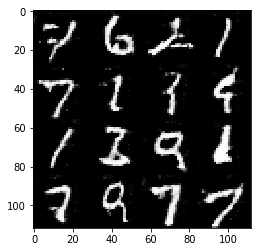

Discriminator Loss: 0.7410... Generator Loss: 1.7200
Discriminator Loss: 1.0744... Generator Loss: 0.8678
Discriminator Loss: 0.8963... Generator Loss: 1.8993
Discriminator Loss: 1.0758... Generator Loss: 0.8572
Discriminator Loss: 0.8470... Generator Loss: 2.1373
Discriminator Loss: 0.8912... Generator Loss: 1.2120
Discriminator Loss: 0.7601... Generator Loss: 1.5953
Discriminator Loss: 1.0497... Generator Loss: 0.8359
Discriminator Loss: 0.7299... Generator Loss: 1.7677
Discriminator Loss: 0.9213... Generator Loss: 1.0633
Discriminator Loss: 0.7982... Generator Loss: 1.2841
Discriminator Loss: 0.7894... Generator Loss: 1.3923
Discriminator Loss: 0.7839... Generator Loss: 1.4139
Discriminator Loss: 0.9052... Generator Loss: 1.0489
Discriminator Loss: 0.8301... Generator Loss: 1.4416
Discriminator Loss: 0.7694... Generator Loss: 1.4695
Discriminator Loss: 0.8731... Generator Loss: 1.1569
Discriminator Loss: 0.8208... Generator Loss: 1.4243
Discriminator Loss: 0.8613... Generator Loss: 

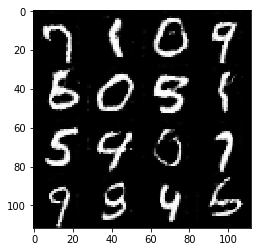

Discriminator Loss: 0.6451... Generator Loss: 1.9552
Discriminator Loss: 0.8168... Generator Loss: 1.2843
Discriminator Loss: 0.6739... Generator Loss: 1.7542
Discriminator Loss: 0.7227... Generator Loss: 1.5121
Discriminator Loss: 1.1668... Generator Loss: 0.7325
Discriminator Loss: 0.7888... Generator Loss: 2.4819
Discriminator Loss: 1.3718... Generator Loss: 0.6065
Discriminator Loss: 0.7067... Generator Loss: 1.7911
Discriminator Loss: 0.7324... Generator Loss: 1.5048
Discriminator Loss: 0.7582... Generator Loss: 1.4432
Discriminator Loss: 0.7843... Generator Loss: 1.4430
Discriminator Loss: 0.7124... Generator Loss: 1.6900
Discriminator Loss: 0.6588... Generator Loss: 1.7575
Discriminator Loss: 0.8017... Generator Loss: 1.3212
Discriminator Loss: 0.8419... Generator Loss: 2.3917
Discriminator Loss: 1.3435... Generator Loss: 0.6638
Discriminator Loss: 0.7466... Generator Loss: 2.4513
Discriminator Loss: 0.8182... Generator Loss: 1.2947
Discriminator Loss: 0.9155... Generator Loss: 

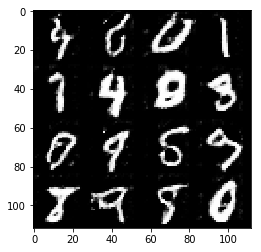

Discriminator Loss: 1.3371... Generator Loss: 0.6427
Discriminator Loss: 0.9263... Generator Loss: 2.5218
Discriminator Loss: 1.3864... Generator Loss: 0.6054
Discriminator Loss: 0.8895... Generator Loss: 2.4290
Discriminator Loss: 0.9596... Generator Loss: 1.0257
Discriminator Loss: 1.1328... Generator Loss: 0.7875
Discriminator Loss: 0.8021... Generator Loss: 1.8076
Discriminator Loss: 0.9234... Generator Loss: 1.0967
Discriminator Loss: 0.7248... Generator Loss: 1.6670
Discriminator Loss: 1.1166... Generator Loss: 0.8001
Discriminator Loss: 0.8129... Generator Loss: 2.2493
Discriminator Loss: 1.2300... Generator Loss: 0.7555
Discriminator Loss: 0.8092... Generator Loss: 2.3663
Discriminator Loss: 0.9155... Generator Loss: 1.1555
Discriminator Loss: 0.7746... Generator Loss: 1.3754
Discriminator Loss: 1.0311... Generator Loss: 0.8697
Discriminator Loss: 0.7715... Generator Loss: 1.4748
Discriminator Loss: 0.7271... Generator Loss: 1.6845
Discriminator Loss: 0.6796... Generator Loss: 

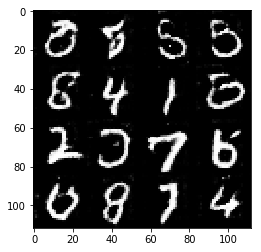

Discriminator Loss: 0.6961... Generator Loss: 1.7939
Discriminator Loss: 0.9187... Generator Loss: 1.1283
Discriminator Loss: 0.6904... Generator Loss: 2.0083
Discriminator Loss: 0.8606... Generator Loss: 1.2891
Discriminator Loss: 0.8358... Generator Loss: 1.2957
Discriminator Loss: 0.7551... Generator Loss: 1.6133
Discriminator Loss: 0.6943... Generator Loss: 1.5961
Discriminator Loss: 1.0397... Generator Loss: 0.9054
Discriminator Loss: 0.7556... Generator Loss: 1.9204
Discriminator Loss: 1.0615... Generator Loss: 0.9068
Discriminator Loss: 0.7429... Generator Loss: 1.7866
Discriminator Loss: 0.8155... Generator Loss: 1.2506
Discriminator Loss: 0.7520... Generator Loss: 1.7483
Discriminator Loss: 0.9549... Generator Loss: 1.0608
Discriminator Loss: 1.0066... Generator Loss: 0.9261
Discriminator Loss: 0.6800... Generator Loss: 2.1393
Discriminator Loss: 0.8871... Generator Loss: 1.1104
Discriminator Loss: 0.7396... Generator Loss: 1.4640
Discriminator Loss: 0.6319... Generator Loss: 

In [39]:
batch_size = 32
z_dim = 24
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

3
(202599, 28, 28, 3)
Tensor("Placeholder:0", shape=(?, 28, 28, 3), dtype=float32)
Discriminator Loss: 7.3280... Generator Loss: 0.0013
Discriminator Loss: 6.0170... Generator Loss: 0.0047
Discriminator Loss: 4.7718... Generator Loss: 0.0178
Discriminator Loss: 3.6199... Generator Loss: 0.0682
Discriminator Loss: 3.6623... Generator Loss: 0.0701
Discriminator Loss: 3.6242... Generator Loss: 0.0780
Discriminator Loss: 2.9629... Generator Loss: 0.1487
Discriminator Loss: 2.4981... Generator Loss: 0.2495
Discriminator Loss: 2.7492... Generator Loss: 0.1890
Discriminator Loss: 2.6039... Generator Loss: 0.2016
Discriminator Loss: 1.9470... Generator Loss: 0.3675
Discriminator Loss: 1.8720... Generator Loss: 0.3848
Discriminator Loss: 1.9654... Generator Loss: 0.3925
Discriminator Loss: 1.7626... Generator Loss: 0.4367
Discriminator Loss: 1.6800... Generator Loss: 0.5868
Discriminator Loss: 1.6327... Generator Loss: 0.5557
Discriminator Loss: 1.2707... Generator Loss: 0.8520
Discriminator Lo

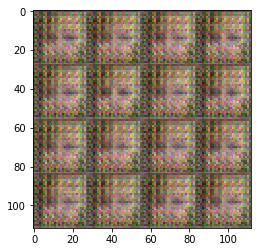

Discriminator Loss: 0.6806... Generator Loss: 2.5357
Discriminator Loss: 0.7903... Generator Loss: 1.7954
Discriminator Loss: 0.6169... Generator Loss: 2.3737
Discriminator Loss: 0.8012... Generator Loss: 1.6297
Discriminator Loss: 0.6185... Generator Loss: 2.4442
Discriminator Loss: 0.6809... Generator Loss: 2.0554
Discriminator Loss: 0.6302... Generator Loss: 2.2860
Discriminator Loss: 0.6700... Generator Loss: 2.2487
Discriminator Loss: 0.6557... Generator Loss: 2.0078
Discriminator Loss: 0.5559... Generator Loss: 2.8226
Discriminator Loss: 0.6968... Generator Loss: 1.9582
Discriminator Loss: 0.6120... Generator Loss: 2.6863
Discriminator Loss: 0.6095... Generator Loss: 2.5931
Discriminator Loss: 0.8309... Generator Loss: 1.2722
Discriminator Loss: 0.7050... Generator Loss: 4.4546
Discriminator Loss: 0.6108... Generator Loss: 2.4061
Discriminator Loss: 1.1406... Generator Loss: 0.8174
Discriminator Loss: 1.1793... Generator Loss: 6.0524
Discriminator Loss: 0.5756... Generator Loss: 

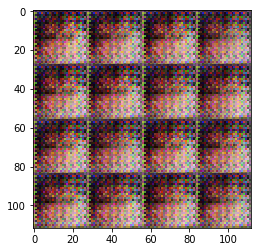

Discriminator Loss: 0.6174... Generator Loss: 2.2217
Discriminator Loss: 0.5339... Generator Loss: 3.2197
Discriminator Loss: 0.5661... Generator Loss: 2.4928
Discriminator Loss: 0.7646... Generator Loss: 1.5512
Discriminator Loss: 0.6325... Generator Loss: 3.9738
Discriminator Loss: 0.5738... Generator Loss: 3.1393
Discriminator Loss: 0.6234... Generator Loss: 1.9473
Discriminator Loss: 0.5189... Generator Loss: 3.7023
Discriminator Loss: 0.5429... Generator Loss: 2.9128
Discriminator Loss: 0.6214... Generator Loss: 1.9476
Discriminator Loss: 0.5884... Generator Loss: 3.2733
Discriminator Loss: 0.5407... Generator Loss: 3.1894
Discriminator Loss: 0.5206... Generator Loss: 3.0875
Discriminator Loss: 0.5270... Generator Loss: 3.1581
Discriminator Loss: 0.6085... Generator Loss: 2.2271
Discriminator Loss: 0.7129... Generator Loss: 1.6732
Discriminator Loss: 0.6023... Generator Loss: 3.1932
Discriminator Loss: 0.5438... Generator Loss: 3.1568
Discriminator Loss: 0.7467... Generator Loss: 

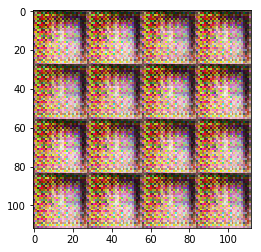

Discriminator Loss: 0.4713... Generator Loss: 3.7286
Discriminator Loss: 0.5147... Generator Loss: 3.2946
Discriminator Loss: 0.4779... Generator Loss: 3.6359
Discriminator Loss: 0.5008... Generator Loss: 3.1633
Discriminator Loss: 0.5000... Generator Loss: 3.1721
Discriminator Loss: 0.5117... Generator Loss: 2.9799
Discriminator Loss: 0.5921... Generator Loss: 2.4600
Discriminator Loss: 0.5036... Generator Loss: 3.5252
Discriminator Loss: 0.5009... Generator Loss: 3.0386
Discriminator Loss: 0.5281... Generator Loss: 3.0578
Discriminator Loss: 0.5281... Generator Loss: 2.7036
Discriminator Loss: 0.5654... Generator Loss: 2.6555
Discriminator Loss: 0.4893... Generator Loss: 3.5594
Discriminator Loss: 0.5344... Generator Loss: 2.6316
Discriminator Loss: 0.5491... Generator Loss: 2.7240
Discriminator Loss: 0.5541... Generator Loss: 2.8546
Discriminator Loss: 0.5066... Generator Loss: 3.2043
Discriminator Loss: 0.6204... Generator Loss: 1.9757
Discriminator Loss: 0.5237... Generator Loss: 

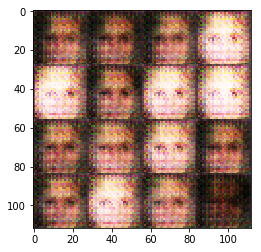

Discriminator Loss: 0.7913... Generator Loss: 2.8944
Discriminator Loss: 0.9345... Generator Loss: 1.1319
Discriminator Loss: 0.7450... Generator Loss: 2.0434
Discriminator Loss: 0.6746... Generator Loss: 2.5371
Discriminator Loss: 0.9338... Generator Loss: 1.2330
Discriminator Loss: 0.7587... Generator Loss: 2.2833
Discriminator Loss: 0.8319... Generator Loss: 1.4103
Discriminator Loss: 0.6909... Generator Loss: 1.8362
Discriminator Loss: 0.6616... Generator Loss: 2.0268
Discriminator Loss: 1.0231... Generator Loss: 0.9589
Discriminator Loss: 0.8098... Generator Loss: 3.1841
Discriminator Loss: 0.8265... Generator Loss: 1.3133
Discriminator Loss: 0.8229... Generator Loss: 1.5598
Discriminator Loss: 0.7845... Generator Loss: 2.4048
Discriminator Loss: 0.9177... Generator Loss: 1.3086
Discriminator Loss: 0.8535... Generator Loss: 2.1229
Discriminator Loss: 0.7596... Generator Loss: 3.0118
Discriminator Loss: 0.6236... Generator Loss: 2.7053
Discriminator Loss: 0.6123... Generator Loss: 

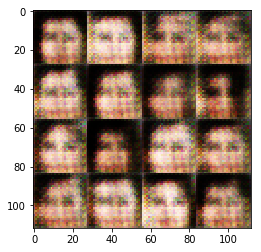

Discriminator Loss: 0.8555... Generator Loss: 1.6424
Discriminator Loss: 1.2633... Generator Loss: 0.7117
Discriminator Loss: 1.4028... Generator Loss: 3.0210
Discriminator Loss: 0.9360... Generator Loss: 1.1838
Discriminator Loss: 1.2669... Generator Loss: 0.6941
Discriminator Loss: 1.2624... Generator Loss: 2.8146
Discriminator Loss: 1.0349... Generator Loss: 1.2188
Discriminator Loss: 1.0856... Generator Loss: 0.8800
Discriminator Loss: 0.8219... Generator Loss: 2.0187
Discriminator Loss: 1.2603... Generator Loss: 0.6835
Discriminator Loss: 0.8298... Generator Loss: 2.0488
Discriminator Loss: 0.9285... Generator Loss: 1.3968
Discriminator Loss: 1.3424... Generator Loss: 0.6699
Discriminator Loss: 1.0718... Generator Loss: 1.2998
Discriminator Loss: 1.0228... Generator Loss: 1.2549
Discriminator Loss: 1.0074... Generator Loss: 1.2846
Discriminator Loss: 1.0449... Generator Loss: 1.3748
Discriminator Loss: 1.1338... Generator Loss: 0.8871
Discriminator Loss: 0.8419... Generator Loss: 

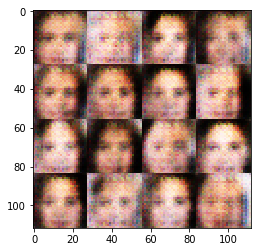

Discriminator Loss: 0.9949... Generator Loss: 1.0986
Discriminator Loss: 0.9249... Generator Loss: 1.5264
Discriminator Loss: 1.3622... Generator Loss: 0.6310
Discriminator Loss: 1.0405... Generator Loss: 2.1941
Discriminator Loss: 0.9251... Generator Loss: 1.5079
Discriminator Loss: 1.1438... Generator Loss: 0.8990
Discriminator Loss: 1.0609... Generator Loss: 0.9793
Discriminator Loss: 1.2814... Generator Loss: 0.8264
Discriminator Loss: 1.1751... Generator Loss: 1.1875
Discriminator Loss: 1.2317... Generator Loss: 0.7902
Discriminator Loss: 1.1945... Generator Loss: 0.9486
Discriminator Loss: 0.9467... Generator Loss: 1.4524
Discriminator Loss: 1.2290... Generator Loss: 0.8076
Discriminator Loss: 0.9221... Generator Loss: 1.6270
Discriminator Loss: 1.0937... Generator Loss: 1.0464
Discriminator Loss: 1.8573... Generator Loss: 0.3285
Discriminator Loss: 1.2419... Generator Loss: 2.4842
Discriminator Loss: 1.0471... Generator Loss: 1.3335
Discriminator Loss: 1.2844... Generator Loss: 

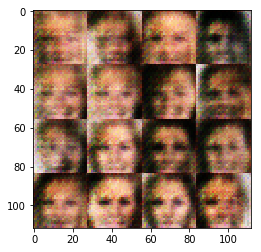

Discriminator Loss: 1.0562... Generator Loss: 1.1455
Discriminator Loss: 1.2731... Generator Loss: 0.8599
Discriminator Loss: 1.3150... Generator Loss: 0.7461
Discriminator Loss: 1.1424... Generator Loss: 1.0459
Discriminator Loss: 1.2524... Generator Loss: 0.7943
Discriminator Loss: 1.3489... Generator Loss: 0.7297
Discriminator Loss: 1.1071... Generator Loss: 1.4249
Discriminator Loss: 1.4190... Generator Loss: 0.5790
Discriminator Loss: 1.0729... Generator Loss: 1.4810
Discriminator Loss: 1.0284... Generator Loss: 1.0620
Discriminator Loss: 1.1214... Generator Loss: 0.9364
Discriminator Loss: 1.0145... Generator Loss: 1.9016
Discriminator Loss: 1.0517... Generator Loss: 1.0145
Discriminator Loss: 0.8972... Generator Loss: 1.3701
Discriminator Loss: 1.0653... Generator Loss: 1.1351
Discriminator Loss: 1.2258... Generator Loss: 0.8514
Discriminator Loss: 1.1468... Generator Loss: 1.0101
Discriminator Loss: 1.0439... Generator Loss: 1.8883
Discriminator Loss: 1.2906... Generator Loss: 

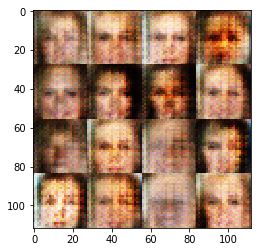

Discriminator Loss: 1.6059... Generator Loss: 0.4892
Discriminator Loss: 1.0374... Generator Loss: 1.2305
Discriminator Loss: 1.2288... Generator Loss: 0.8933
Discriminator Loss: 1.0963... Generator Loss: 1.1594
Discriminator Loss: 1.4061... Generator Loss: 0.5753
Discriminator Loss: 1.2166... Generator Loss: 1.1343
Discriminator Loss: 1.4184... Generator Loss: 0.6266
Discriminator Loss: 1.3714... Generator Loss: 0.7175
Discriminator Loss: 1.4352... Generator Loss: 0.9296
Discriminator Loss: 1.2104... Generator Loss: 1.1307
Discriminator Loss: 1.9003... Generator Loss: 0.3549
Discriminator Loss: 1.3820... Generator Loss: 1.9994
Discriminator Loss: 1.1824... Generator Loss: 1.0834
Discriminator Loss: 1.6051... Generator Loss: 0.4914
Discriminator Loss: 1.3029... Generator Loss: 1.5209
Discriminator Loss: 1.2787... Generator Loss: 0.7996
Discriminator Loss: 1.1277... Generator Loss: 1.0364
Discriminator Loss: 1.1294... Generator Loss: 0.8875
Discriminator Loss: 1.1316... Generator Loss: 

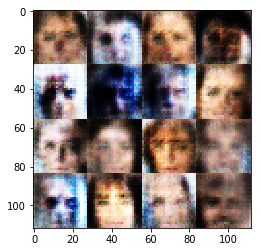

Discriminator Loss: 1.1105... Generator Loss: 0.8808
Discriminator Loss: 1.3032... Generator Loss: 0.8710
Discriminator Loss: 1.1461... Generator Loss: 0.8846
Discriminator Loss: 1.2629... Generator Loss: 1.0910
Discriminator Loss: 1.3766... Generator Loss: 0.5701
Discriminator Loss: 1.1752... Generator Loss: 1.4070
Discriminator Loss: 1.4242... Generator Loss: 0.5858
Discriminator Loss: 1.2652... Generator Loss: 0.9294
Discriminator Loss: 1.3204... Generator Loss: 1.2029
Discriminator Loss: 1.7789... Generator Loss: 0.3428
Discriminator Loss: 1.6050... Generator Loss: 2.4363
Discriminator Loss: 1.5430... Generator Loss: 0.5146
Discriminator Loss: 1.3037... Generator Loss: 1.1865
Discriminator Loss: 1.1302... Generator Loss: 1.2459
Discriminator Loss: 1.6706... Generator Loss: 0.4530
Discriminator Loss: 1.3031... Generator Loss: 1.2773
Discriminator Loss: 1.2251... Generator Loss: 0.7478
Discriminator Loss: 1.4629... Generator Loss: 0.7889
Discriminator Loss: 1.1945... Generator Loss: 

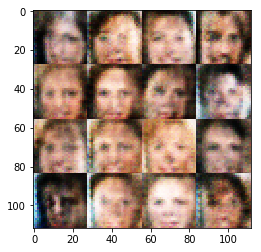

Discriminator Loss: 1.1907... Generator Loss: 1.0967
Discriminator Loss: 1.4008... Generator Loss: 0.6218
Discriminator Loss: 1.2998... Generator Loss: 1.3275
Discriminator Loss: 1.4915... Generator Loss: 0.5393
Discriminator Loss: 1.3101... Generator Loss: 0.8576
Discriminator Loss: 1.2237... Generator Loss: 1.3046
Discriminator Loss: 1.2867... Generator Loss: 0.8641
Discriminator Loss: 1.3941... Generator Loss: 0.7359
Discriminator Loss: 1.2982... Generator Loss: 1.2501
Discriminator Loss: 1.3097... Generator Loss: 0.6906
Discriminator Loss: 1.2373... Generator Loss: 0.9231
Discriminator Loss: 1.2021... Generator Loss: 0.8492
Discriminator Loss: 1.3724... Generator Loss: 0.7980
Discriminator Loss: 1.3142... Generator Loss: 1.0175
Discriminator Loss: 1.4804... Generator Loss: 0.5410
Discriminator Loss: 1.2952... Generator Loss: 1.0041
Discriminator Loss: 1.1589... Generator Loss: 1.0508
Discriminator Loss: 1.1815... Generator Loss: 0.8597
Discriminator Loss: 1.3222... Generator Loss: 

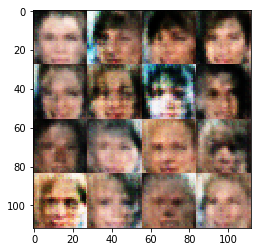

Discriminator Loss: 1.3650... Generator Loss: 0.7858
Discriminator Loss: 1.3788... Generator Loss: 1.1381
Discriminator Loss: 1.4926... Generator Loss: 0.5625
Discriminator Loss: 1.1854... Generator Loss: 0.9920
Discriminator Loss: 1.2985... Generator Loss: 1.0818
Discriminator Loss: 1.5069... Generator Loss: 0.5210
Discriminator Loss: 1.3379... Generator Loss: 1.0369
Discriminator Loss: 1.3504... Generator Loss: 0.7677
Discriminator Loss: 1.4247... Generator Loss: 0.6785
Discriminator Loss: 1.3610... Generator Loss: 0.8366
Discriminator Loss: 1.1384... Generator Loss: 1.2650
Discriminator Loss: 1.5001... Generator Loss: 0.5250
Discriminator Loss: 1.2264... Generator Loss: 1.2306
Discriminator Loss: 0.9335... Generator Loss: 1.4535
Discriminator Loss: 1.3169... Generator Loss: 0.6532
Discriminator Loss: 1.1514... Generator Loss: 1.0730
Discriminator Loss: 1.1903... Generator Loss: 0.9489
Discriminator Loss: 1.3629... Generator Loss: 0.6377
Discriminator Loss: 1.3413... Generator Loss: 

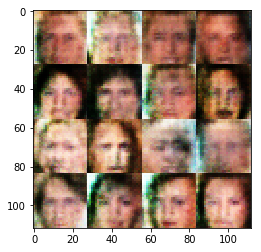

Discriminator Loss: 1.2124... Generator Loss: 0.9928
Discriminator Loss: 1.4207... Generator Loss: 0.7116
Discriminator Loss: 1.2944... Generator Loss: 0.8514
Discriminator Loss: 1.4586... Generator Loss: 0.5677
Discriminator Loss: 1.3995... Generator Loss: 1.8433
Discriminator Loss: 1.3963... Generator Loss: 0.5975
Discriminator Loss: 1.4483... Generator Loss: 0.6241
Discriminator Loss: 1.2821... Generator Loss: 1.2204
Discriminator Loss: 1.2889... Generator Loss: 0.7815
Discriminator Loss: 1.2279... Generator Loss: 1.0467
Discriminator Loss: 1.1960... Generator Loss: 0.9298
Discriminator Loss: 1.5442... Generator Loss: 0.5409
Discriminator Loss: 1.1553... Generator Loss: 1.7290
Discriminator Loss: 1.1559... Generator Loss: 0.9343
Discriminator Loss: 1.3254... Generator Loss: 0.6932
Discriminator Loss: 1.1042... Generator Loss: 1.1900
Discriminator Loss: 1.4855... Generator Loss: 0.6138
Discriminator Loss: 1.3551... Generator Loss: 1.4102
Discriminator Loss: 1.4038... Generator Loss: 

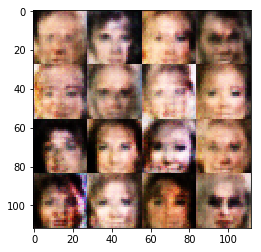

Discriminator Loss: 1.3458... Generator Loss: 0.6634
Discriminator Loss: 1.3503... Generator Loss: 0.9083
Discriminator Loss: 1.2386... Generator Loss: 0.9965
Discriminator Loss: 1.4394... Generator Loss: 0.5655
Discriminator Loss: 1.3643... Generator Loss: 0.9420
Discriminator Loss: 1.4128... Generator Loss: 0.7455
Discriminator Loss: 1.2964... Generator Loss: 0.9207
Discriminator Loss: 1.2199... Generator Loss: 0.8852
Discriminator Loss: 1.4786... Generator Loss: 0.5327
Discriminator Loss: 1.4056... Generator Loss: 1.2365
Discriminator Loss: 1.3182... Generator Loss: 0.8040
Discriminator Loss: 1.4842... Generator Loss: 0.5471
Discriminator Loss: 1.3615... Generator Loss: 1.1485
Discriminator Loss: 1.3912... Generator Loss: 0.6998
Discriminator Loss: 1.2352... Generator Loss: 1.0695
Discriminator Loss: 1.3697... Generator Loss: 0.6231
Discriminator Loss: 1.1572... Generator Loss: 1.0615
Discriminator Loss: 1.2100... Generator Loss: 0.8803
Discriminator Loss: 1.1931... Generator Loss: 

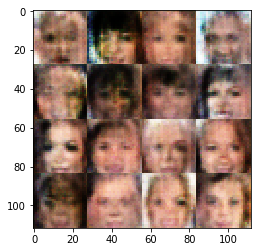

Discriminator Loss: 1.3348... Generator Loss: 0.7936
Discriminator Loss: 1.5530... Generator Loss: 0.5434
Discriminator Loss: 1.3889... Generator Loss: 1.0472
Discriminator Loss: 1.4353... Generator Loss: 0.5830
Discriminator Loss: 1.3265... Generator Loss: 1.0783
Discriminator Loss: 1.1945... Generator Loss: 0.8279
Discriminator Loss: 1.2714... Generator Loss: 0.8748
Discriminator Loss: 1.4036... Generator Loss: 0.6824
Discriminator Loss: 1.2765... Generator Loss: 0.8595
Discriminator Loss: 1.3778... Generator Loss: 0.8183
Discriminator Loss: 1.2573... Generator Loss: 0.8592
Discriminator Loss: 1.2576... Generator Loss: 0.8999
Discriminator Loss: 1.3988... Generator Loss: 0.6536
Discriminator Loss: 1.3829... Generator Loss: 0.9627
Discriminator Loss: 1.2300... Generator Loss: 0.7562
Discriminator Loss: 1.2586... Generator Loss: 0.8085
Discriminator Loss: 1.3644... Generator Loss: 1.0083
Discriminator Loss: 1.3001... Generator Loss: 0.7896
Discriminator Loss: 1.4671... Generator Loss: 

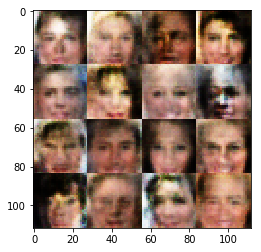

Discriminator Loss: 1.2211... Generator Loss: 0.7175
Discriminator Loss: 1.3545... Generator Loss: 1.1400
Discriminator Loss: 1.2374... Generator Loss: 0.7040
Discriminator Loss: 1.2145... Generator Loss: 1.0995
Discriminator Loss: 1.2360... Generator Loss: 0.9849
Discriminator Loss: 1.3549... Generator Loss: 0.6511
Discriminator Loss: 1.3078... Generator Loss: 0.8740
Discriminator Loss: 1.2914... Generator Loss: 1.0276
Discriminator Loss: 1.2415... Generator Loss: 0.8108
Discriminator Loss: 1.3544... Generator Loss: 0.7008
Discriminator Loss: 1.2790... Generator Loss: 1.1236
Discriminator Loss: 1.4505... Generator Loss: 0.6287
Discriminator Loss: 1.3470... Generator Loss: 0.9254
Discriminator Loss: 1.5084... Generator Loss: 0.7642
Discriminator Loss: 1.3140... Generator Loss: 0.7109
Discriminator Loss: 1.2112... Generator Loss: 0.8961
Discriminator Loss: 1.2816... Generator Loss: 0.8388
Discriminator Loss: 1.2697... Generator Loss: 0.7672
Discriminator Loss: 1.3494... Generator Loss: 

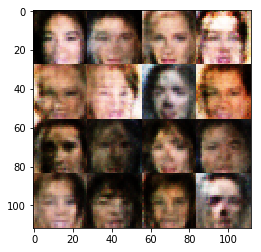

Discriminator Loss: 1.2803... Generator Loss: 1.1823
Discriminator Loss: 1.1804... Generator Loss: 0.7755
Discriminator Loss: 1.3375... Generator Loss: 0.7508
Discriminator Loss: 1.4043... Generator Loss: 0.8532
Discriminator Loss: 1.3878... Generator Loss: 0.7643
Discriminator Loss: 1.2062... Generator Loss: 1.0646
Discriminator Loss: 1.2829... Generator Loss: 0.7647
Discriminator Loss: 1.3114... Generator Loss: 0.7821
Discriminator Loss: 1.4045... Generator Loss: 0.6668
Discriminator Loss: 1.4471... Generator Loss: 0.7757
Discriminator Loss: 1.4399... Generator Loss: 0.7605
Discriminator Loss: 1.4038... Generator Loss: 0.6683
Discriminator Loss: 1.3875... Generator Loss: 0.6734
Discriminator Loss: 1.2967... Generator Loss: 1.0788
Discriminator Loss: 1.3418... Generator Loss: 0.6417
Discriminator Loss: 1.2348... Generator Loss: 0.9337
Discriminator Loss: 1.1707... Generator Loss: 0.9748
Discriminator Loss: 1.3145... Generator Loss: 0.7617
Discriminator Loss: 1.2983... Generator Loss: 

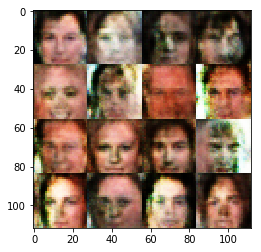

Discriminator Loss: 1.4309... Generator Loss: 0.8316
Discriminator Loss: 1.3438... Generator Loss: 0.8770
Discriminator Loss: 1.3982... Generator Loss: 0.6506
Discriminator Loss: 1.2042... Generator Loss: 1.1605
Discriminator Loss: 1.1106... Generator Loss: 0.8531
Discriminator Loss: 1.3767... Generator Loss: 0.6888
Discriminator Loss: 1.3146... Generator Loss: 1.3177
Discriminator Loss: 1.2628... Generator Loss: 0.7731
Discriminator Loss: 1.4520... Generator Loss: 0.6208
Discriminator Loss: 1.3196... Generator Loss: 1.1962
Discriminator Loss: 1.3362... Generator Loss: 0.6686
Discriminator Loss: 1.2549... Generator Loss: 0.9078
Discriminator Loss: 1.2515... Generator Loss: 0.9004
Discriminator Loss: 1.1100... Generator Loss: 0.9555
Discriminator Loss: 1.2371... Generator Loss: 0.7625
Discriminator Loss: 1.3212... Generator Loss: 0.8057
Discriminator Loss: 1.2785... Generator Loss: 0.9770
Discriminator Loss: 1.2842... Generator Loss: 0.8127
Discriminator Loss: 1.3855... Generator Loss: 

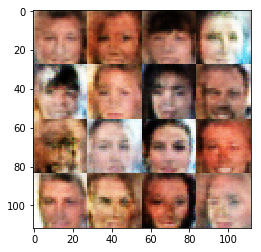

Discriminator Loss: 1.3400... Generator Loss: 0.6683
Discriminator Loss: 1.1676... Generator Loss: 1.0740
Discriminator Loss: 1.1531... Generator Loss: 0.9338
Discriminator Loss: 1.2261... Generator Loss: 0.7224
Discriminator Loss: 1.2684... Generator Loss: 0.9285
Discriminator Loss: 1.2340... Generator Loss: 1.1777
Discriminator Loss: 1.2924... Generator Loss: 0.7372
Discriminator Loss: 1.3173... Generator Loss: 0.6549
Discriminator Loss: 1.0789... Generator Loss: 1.4548
Discriminator Loss: 1.2600... Generator Loss: 0.7786
Discriminator Loss: 1.3469... Generator Loss: 0.6448
Discriminator Loss: 1.3017... Generator Loss: 1.0465
Discriminator Loss: 1.2326... Generator Loss: 0.8835
Discriminator Loss: 1.3872... Generator Loss: 0.6173
Discriminator Loss: 1.2160... Generator Loss: 1.0000
Discriminator Loss: 1.3323... Generator Loss: 0.8370
Discriminator Loss: 1.4462... Generator Loss: 0.6464
Discriminator Loss: 1.1777... Generator Loss: 0.9956
Discriminator Loss: 1.3972... Generator Loss: 

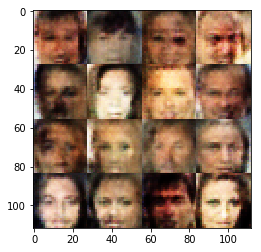

Discriminator Loss: 1.2367... Generator Loss: 0.9865
Discriminator Loss: 1.4062... Generator Loss: 0.7042
Discriminator Loss: 1.3847... Generator Loss: 0.6279
Discriminator Loss: 1.3915... Generator Loss: 0.8676
Discriminator Loss: 1.2959... Generator Loss: 0.8423
Discriminator Loss: 1.1910... Generator Loss: 0.9176
Discriminator Loss: 1.3098... Generator Loss: 0.6972
Discriminator Loss: 1.3262... Generator Loss: 0.8340
Discriminator Loss: 1.1793... Generator Loss: 0.8756
Discriminator Loss: 1.2457... Generator Loss: 0.9687
Discriminator Loss: 1.3478... Generator Loss: 0.6502
Discriminator Loss: 1.1611... Generator Loss: 1.1709
Discriminator Loss: 1.4796... Generator Loss: 0.5387
Discriminator Loss: 1.2131... Generator Loss: 0.9198
Discriminator Loss: 1.2092... Generator Loss: 0.9554
Discriminator Loss: 1.3220... Generator Loss: 0.7076
Discriminator Loss: 1.4278... Generator Loss: 0.6434
Discriminator Loss: 1.5227... Generator Loss: 0.5513
Discriminator Loss: 1.2518... Generator Loss: 

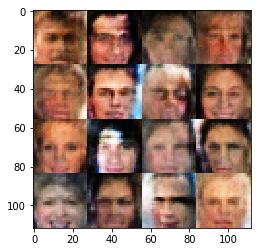

Discriminator Loss: 1.1949... Generator Loss: 0.9473
Discriminator Loss: 1.4374... Generator Loss: 0.5698
Discriminator Loss: 1.3015... Generator Loss: 0.8048
Discriminator Loss: 1.2225... Generator Loss: 0.9365
Discriminator Loss: 1.3875... Generator Loss: 0.6305
Discriminator Loss: 1.4301... Generator Loss: 0.6503
Discriminator Loss: 1.2412... Generator Loss: 0.9546
Discriminator Loss: 1.2807... Generator Loss: 0.7061
Discriminator Loss: 1.3091... Generator Loss: 0.7583
Discriminator Loss: 1.3062... Generator Loss: 0.8058
Discriminator Loss: 1.3979... Generator Loss: 0.6954
Discriminator Loss: 1.1994... Generator Loss: 1.1145
Discriminator Loss: 1.3377... Generator Loss: 0.6961
Discriminator Loss: 1.3852... Generator Loss: 0.7551
Discriminator Loss: 1.3608... Generator Loss: 0.8589
Discriminator Loss: 1.2587... Generator Loss: 0.7911
Discriminator Loss: 1.2984... Generator Loss: 0.8019
Discriminator Loss: 1.2436... Generator Loss: 0.8454
Discriminator Loss: 1.2539... Generator Loss: 

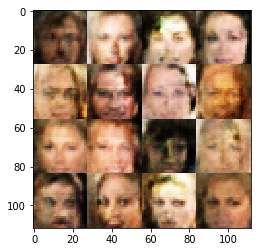

Discriminator Loss: 1.3049... Generator Loss: 0.7887
Discriminator Loss: 1.4031... Generator Loss: 0.7194
Discriminator Loss: 1.3285... Generator Loss: 0.9678
Discriminator Loss: 1.2772... Generator Loss: 0.7148
Discriminator Loss: 1.3268... Generator Loss: 0.7931
Discriminator Loss: 1.4520... Generator Loss: 0.6821
Discriminator Loss: 1.3113... Generator Loss: 0.8946
Discriminator Loss: 1.1628... Generator Loss: 0.9046
Discriminator Loss: 1.2932... Generator Loss: 0.7751
Discriminator Loss: 1.2757... Generator Loss: 0.7346
Discriminator Loss: 1.2231... Generator Loss: 1.1105
Discriminator Loss: 1.2687... Generator Loss: 0.7276
Discriminator Loss: 1.2864... Generator Loss: 0.7266
Discriminator Loss: 1.2281... Generator Loss: 0.9264
Discriminator Loss: 1.2378... Generator Loss: 0.8191
Discriminator Loss: 1.3147... Generator Loss: 0.6793
Discriminator Loss: 1.2285... Generator Loss: 1.0105
Discriminator Loss: 1.3919... Generator Loss: 0.6618
Discriminator Loss: 1.1641... Generator Loss: 

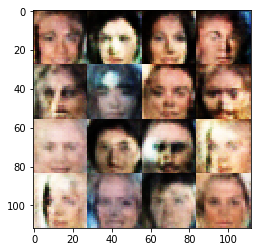

Discriminator Loss: 1.2723... Generator Loss: 0.8587
Discriminator Loss: 1.2334... Generator Loss: 0.7070
Discriminator Loss: 1.2639... Generator Loss: 0.7860
Discriminator Loss: 1.2837... Generator Loss: 0.8442
Discriminator Loss: 1.3778... Generator Loss: 0.7071
Discriminator Loss: 1.4138... Generator Loss: 0.6315
Discriminator Loss: 1.2815... Generator Loss: 0.7610
Discriminator Loss: 1.3819... Generator Loss: 0.6711
Discriminator Loss: 1.3506... Generator Loss: 0.7486
Discriminator Loss: 1.3204... Generator Loss: 0.7880
Discriminator Loss: 1.2229... Generator Loss: 0.9113
Discriminator Loss: 1.2620... Generator Loss: 0.9156
Discriminator Loss: 1.3923... Generator Loss: 0.5554
Discriminator Loss: 1.3487... Generator Loss: 0.7436
Discriminator Loss: 1.3337... Generator Loss: 0.8471
Discriminator Loss: 1.3525... Generator Loss: 0.7456
Discriminator Loss: 1.4463... Generator Loss: 0.6132
Discriminator Loss: 1.2851... Generator Loss: 1.1045
Discriminator Loss: 1.3151... Generator Loss: 

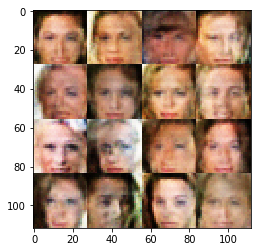

Discriminator Loss: 1.3148... Generator Loss: 0.7965
Discriminator Loss: 1.3033... Generator Loss: 0.9045
Discriminator Loss: 1.3731... Generator Loss: 0.6623
Discriminator Loss: 1.1576... Generator Loss: 1.0691
Discriminator Loss: 1.3381... Generator Loss: 0.6970
Discriminator Loss: 1.3661... Generator Loss: 0.6633
Discriminator Loss: 1.2102... Generator Loss: 1.0792
Discriminator Loss: 1.2825... Generator Loss: 0.7583
Discriminator Loss: 1.2535... Generator Loss: 0.8046
Discriminator Loss: 1.4433... Generator Loss: 0.5492
Discriminator Loss: 1.5069... Generator Loss: 0.8434
Discriminator Loss: 1.2257... Generator Loss: 0.9519
Discriminator Loss: 1.3206... Generator Loss: 0.6992
Discriminator Loss: 1.2309... Generator Loss: 0.8499
Discriminator Loss: 1.2840... Generator Loss: 0.7382
Discriminator Loss: 1.1313... Generator Loss: 1.2198
Discriminator Loss: 1.1661... Generator Loss: 0.8238
Discriminator Loss: 1.2969... Generator Loss: 0.6865
Discriminator Loss: 1.1026... Generator Loss: 

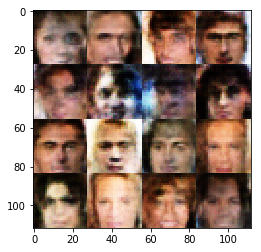

Discriminator Loss: 1.2225... Generator Loss: 0.8876
Discriminator Loss: 1.2371... Generator Loss: 0.8048
Discriminator Loss: 1.1751... Generator Loss: 0.8571
Discriminator Loss: 1.4299... Generator Loss: 0.9147
Discriminator Loss: 1.2691... Generator Loss: 0.8191
Discriminator Loss: 1.3697... Generator Loss: 0.6170
Discriminator Loss: 1.2634... Generator Loss: 0.9445
Discriminator Loss: 1.2404... Generator Loss: 0.7688
Discriminator Loss: 1.3353... Generator Loss: 0.6656
Discriminator Loss: 1.2117... Generator Loss: 1.2820
Discriminator Loss: 1.4820... Generator Loss: 0.5595
Discriminator Loss: 1.2559... Generator Loss: 0.9671
Discriminator Loss: 1.3168... Generator Loss: 0.6992
Discriminator Loss: 1.2900... Generator Loss: 0.8448
Discriminator Loss: 1.1798... Generator Loss: 0.9451
Discriminator Loss: 1.4079... Generator Loss: 0.6427
Discriminator Loss: 1.3858... Generator Loss: 0.8827
Discriminator Loss: 1.2733... Generator Loss: 0.7862
Discriminator Loss: 1.4232... Generator Loss: 

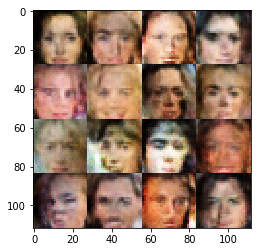

Discriminator Loss: 1.2932... Generator Loss: 0.8812
Discriminator Loss: 1.4518... Generator Loss: 0.6701
Discriminator Loss: 1.5045... Generator Loss: 0.5673
Discriminator Loss: 1.2134... Generator Loss: 0.9498
Discriminator Loss: 1.2427... Generator Loss: 0.7819
Discriminator Loss: 1.2430... Generator Loss: 0.9101
Discriminator Loss: 1.2927... Generator Loss: 0.8446
Discriminator Loss: 1.3478... Generator Loss: 0.6834
Discriminator Loss: 1.2527... Generator Loss: 0.8499
Discriminator Loss: 1.2853... Generator Loss: 0.7762
Discriminator Loss: 1.1699... Generator Loss: 1.2248
Discriminator Loss: 1.1939... Generator Loss: 0.7476
Discriminator Loss: 1.2007... Generator Loss: 0.9225
Discriminator Loss: 1.5251... Generator Loss: 0.4983
Discriminator Loss: 1.2218... Generator Loss: 1.0561
Discriminator Loss: 1.4620... Generator Loss: 0.6877
Discriminator Loss: 1.3591... Generator Loss: 0.7342
Discriminator Loss: 1.0758... Generator Loss: 1.1213
Discriminator Loss: 1.2470... Generator Loss: 

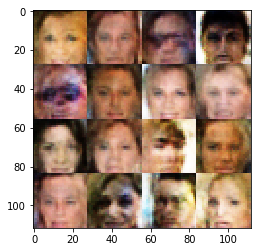

Discriminator Loss: 1.4098... Generator Loss: 0.6273
Discriminator Loss: 1.2431... Generator Loss: 0.8726
Discriminator Loss: 1.3562... Generator Loss: 0.8532
Discriminator Loss: 1.2390... Generator Loss: 0.8424
Discriminator Loss: 1.2704... Generator Loss: 0.7536
Discriminator Loss: 1.3153... Generator Loss: 0.7586
Discriminator Loss: 1.4809... Generator Loss: 0.7012
Discriminator Loss: 1.3281... Generator Loss: 0.6892
Discriminator Loss: 1.2056... Generator Loss: 1.0010
Discriminator Loss: 1.1580... Generator Loss: 0.8726
Discriminator Loss: 1.4514... Generator Loss: 0.5875
Discriminator Loss: 1.2785... Generator Loss: 0.8442
Discriminator Loss: 1.3405... Generator Loss: 0.6967
Discriminator Loss: 1.1840... Generator Loss: 1.1269
Discriminator Loss: 1.4239... Generator Loss: 0.6532
Discriminator Loss: 1.3235... Generator Loss: 0.6935
Discriminator Loss: 1.1964... Generator Loss: 1.1486
Discriminator Loss: 1.3308... Generator Loss: 0.6569
Discriminator Loss: 1.3107... Generator Loss: 

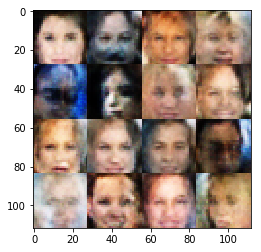

Discriminator Loss: 1.0821... Generator Loss: 1.2954
Discriminator Loss: 1.3070... Generator Loss: 0.7018
Discriminator Loss: 1.5462... Generator Loss: 0.5280
Discriminator Loss: 1.3009... Generator Loss: 1.1695
Discriminator Loss: 1.3226... Generator Loss: 0.6680
Discriminator Loss: 1.4760... Generator Loss: 0.5887
Discriminator Loss: 1.2725... Generator Loss: 1.1147
Discriminator Loss: 1.0813... Generator Loss: 1.1317
Discriminator Loss: 1.3205... Generator Loss: 0.6308
Discriminator Loss: 1.2506... Generator Loss: 0.7885
Discriminator Loss: 1.4700... Generator Loss: 0.7615
Discriminator Loss: 1.1014... Generator Loss: 1.0934
Discriminator Loss: 1.3866... Generator Loss: 0.6593
Discriminator Loss: 1.3090... Generator Loss: 0.9067
Discriminator Loss: 1.2667... Generator Loss: 0.7847
Discriminator Loss: 1.2967... Generator Loss: 0.7172
Discriminator Loss: 1.2962... Generator Loss: 0.7770
Discriminator Loss: 1.3636... Generator Loss: 0.6430
Discriminator Loss: 1.2214... Generator Loss: 

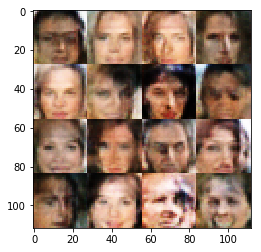

Discriminator Loss: 1.1249... Generator Loss: 1.1645
Discriminator Loss: 1.0616... Generator Loss: 1.1769
Discriminator Loss: 1.7240... Generator Loss: 0.4191
Discriminator Loss: 1.2091... Generator Loss: 0.8725
Discriminator Loss: 1.1383... Generator Loss: 1.2770
Discriminator Loss: 1.5227... Generator Loss: 0.5400
Discriminator Loss: 1.2507... Generator Loss: 0.7469
Discriminator Loss: 1.1276... Generator Loss: 1.1299
Discriminator Loss: 1.2952... Generator Loss: 0.6608
Discriminator Loss: 1.4719... Generator Loss: 0.5863
Discriminator Loss: 1.2984... Generator Loss: 0.7168
Discriminator Loss: 1.3993... Generator Loss: 0.6937
Discriminator Loss: 1.2470... Generator Loss: 0.8651
Discriminator Loss: 1.2207... Generator Loss: 0.8613
Discriminator Loss: 1.3517... Generator Loss: 0.6838
Discriminator Loss: 1.4508... Generator Loss: 0.6232
Discriminator Loss: 1.0839... Generator Loss: 1.2335
Discriminator Loss: 1.5206... Generator Loss: 0.5283
Discriminator Loss: 1.3624... Generator Loss: 

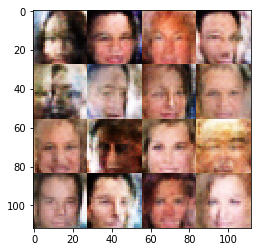

Discriminator Loss: 1.2239... Generator Loss: 0.8799
Discriminator Loss: 1.4310... Generator Loss: 0.6314
Discriminator Loss: 1.0957... Generator Loss: 1.1015
Discriminator Loss: 1.2804... Generator Loss: 0.6698
Discriminator Loss: 1.3519... Generator Loss: 0.8333
Discriminator Loss: 1.4185... Generator Loss: 0.6714
Discriminator Loss: 1.2809... Generator Loss: 0.7607
Discriminator Loss: 1.3117... Generator Loss: 0.8302
Discriminator Loss: 1.6385... Generator Loss: 0.4568
Discriminator Loss: 1.2366... Generator Loss: 0.8163
Discriminator Loss: 1.4906... Generator Loss: 0.6850
Discriminator Loss: 1.2763... Generator Loss: 0.7912
Discriminator Loss: 1.2572... Generator Loss: 0.7591
Discriminator Loss: 1.1941... Generator Loss: 0.8437
Discriminator Loss: 1.2920... Generator Loss: 0.7573
Discriminator Loss: 1.3932... Generator Loss: 0.7296
Discriminator Loss: 1.3693... Generator Loss: 0.8563
Discriminator Loss: 1.2255... Generator Loss: 0.8761
Discriminator Loss: 1.2938... Generator Loss: 

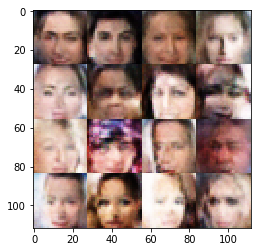

Discriminator Loss: 1.2363... Generator Loss: 0.8054
Discriminator Loss: 1.2925... Generator Loss: 0.6672
Discriminator Loss: 1.3060... Generator Loss: 0.8673
Discriminator Loss: 1.2277... Generator Loss: 0.9068
Discriminator Loss: 1.3846... Generator Loss: 0.7638
Discriminator Loss: 1.3917... Generator Loss: 0.6628
Discriminator Loss: 1.3316... Generator Loss: 0.7914
Discriminator Loss: 1.3106... Generator Loss: 0.7461
Discriminator Loss: 1.2603... Generator Loss: 0.8773
Discriminator Loss: 1.3234... Generator Loss: 0.8572
Discriminator Loss: 1.2446... Generator Loss: 0.7980
Discriminator Loss: 1.0877... Generator Loss: 1.1403
Discriminator Loss: 1.4629... Generator Loss: 0.5266
Discriminator Loss: 1.2862... Generator Loss: 0.9935
Discriminator Loss: 1.3129... Generator Loss: 0.8557
Discriminator Loss: 1.2638... Generator Loss: 0.6967
Discriminator Loss: 1.2588... Generator Loss: 1.0615
Discriminator Loss: 1.2369... Generator Loss: 0.8291
Discriminator Loss: 1.2109... Generator Loss: 

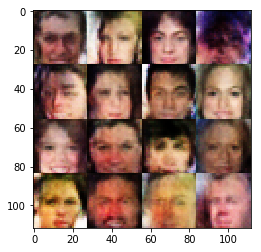

Discriminator Loss: 1.4898... Generator Loss: 0.5435
Discriminator Loss: 1.4518... Generator Loss: 0.6548
Discriminator Loss: 1.4620... Generator Loss: 0.7658
Discriminator Loss: 1.3483... Generator Loss: 0.6489
Discriminator Loss: 1.2653... Generator Loss: 0.8029
Discriminator Loss: 1.5022... Generator Loss: 0.7777
Discriminator Loss: 1.4857... Generator Loss: 0.6166
Discriminator Loss: 1.4815... Generator Loss: 0.6418
Discriminator Loss: 1.1611... Generator Loss: 0.9244
Discriminator Loss: 1.3524... Generator Loss: 0.7427
Discriminator Loss: 1.0884... Generator Loss: 1.0841
Discriminator Loss: 1.3290... Generator Loss: 0.6872
Discriminator Loss: 1.1913... Generator Loss: 0.9719
Discriminator Loss: 1.3466... Generator Loss: 0.7425
Discriminator Loss: 1.4145... Generator Loss: 0.6487
Discriminator Loss: 1.2988... Generator Loss: 0.9070
Discriminator Loss: 1.3170... Generator Loss: 0.8617
Discriminator Loss: 1.2844... Generator Loss: 0.7459
Discriminator Loss: 1.1031... Generator Loss: 

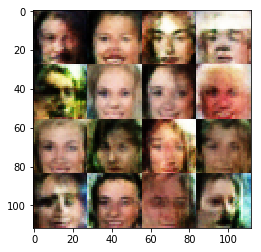

Discriminator Loss: 1.3915... Generator Loss: 0.6636
Discriminator Loss: 1.2622... Generator Loss: 0.7992
Discriminator Loss: 1.4233... Generator Loss: 0.5821
Discriminator Loss: 1.2092... Generator Loss: 0.9307
Discriminator Loss: 1.2425... Generator Loss: 0.8714
Discriminator Loss: 1.4501... Generator Loss: 0.6514
Discriminator Loss: 1.3081... Generator Loss: 0.6535
Discriminator Loss: 1.3459... Generator Loss: 0.8660
Discriminator Loss: 1.4141... Generator Loss: 0.7414
Discriminator Loss: 1.3460... Generator Loss: 0.8418
Discriminator Loss: 1.4389... Generator Loss: 0.5344
Discriminator Loss: 1.2462... Generator Loss: 1.3500
Discriminator Loss: 1.4226... Generator Loss: 0.6062
Discriminator Loss: 1.2181... Generator Loss: 0.8737
Discriminator Loss: 1.4645... Generator Loss: 0.7807
Discriminator Loss: 1.4189... Generator Loss: 0.5880
Discriminator Loss: 1.4238... Generator Loss: 0.7784
Discriminator Loss: 1.5106... Generator Loss: 0.6802
Discriminator Loss: 1.3459... Generator Loss: 

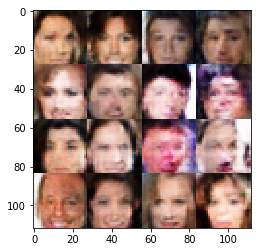

Discriminator Loss: 1.3878... Generator Loss: 0.7371
Discriminator Loss: 1.2052... Generator Loss: 0.8939
Discriminator Loss: 1.4377... Generator Loss: 0.6977
Discriminator Loss: 1.1888... Generator Loss: 0.9071
Discriminator Loss: 1.2697... Generator Loss: 0.7401
Discriminator Loss: 1.2903... Generator Loss: 0.8408
Discriminator Loss: 1.3785... Generator Loss: 0.6320
Discriminator Loss: 1.4137... Generator Loss: 0.6851
Discriminator Loss: 1.2372... Generator Loss: 0.8359
Discriminator Loss: 1.3492... Generator Loss: 0.8483
Discriminator Loss: 1.3739... Generator Loss: 0.7490
Discriminator Loss: 1.1401... Generator Loss: 0.9008
Discriminator Loss: 1.1682... Generator Loss: 1.0628
Discriminator Loss: 1.1008... Generator Loss: 1.0148
Discriminator Loss: 1.4190... Generator Loss: 0.5869
Discriminator Loss: 1.3557... Generator Loss: 0.7562
Discriminator Loss: 1.3484... Generator Loss: 0.8448
Discriminator Loss: 1.3039... Generator Loss: 0.7201
Discriminator Loss: 1.2396... Generator Loss: 

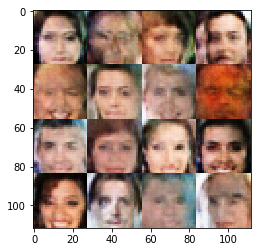

Discriminator Loss: 1.5074... Generator Loss: 0.5049
Discriminator Loss: 1.3555... Generator Loss: 0.8857
Discriminator Loss: 1.2669... Generator Loss: 0.8619
Discriminator Loss: 1.4942... Generator Loss: 0.5754
Discriminator Loss: 1.4587... Generator Loss: 0.6607
Discriminator Loss: 1.3589... Generator Loss: 0.6608
Discriminator Loss: 1.3278... Generator Loss: 0.8483
Discriminator Loss: 1.3424... Generator Loss: 0.8293
Discriminator Loss: 1.5919... Generator Loss: 0.4795
Discriminator Loss: 1.3281... Generator Loss: 0.9466
Discriminator Loss: 1.3386... Generator Loss: 0.7945
Discriminator Loss: 1.4197... Generator Loss: 0.6926
Discriminator Loss: 1.3488... Generator Loss: 0.7056
Discriminator Loss: 1.3854... Generator Loss: 0.5725
Discriminator Loss: 1.1590... Generator Loss: 1.1702
Discriminator Loss: 1.2704... Generator Loss: 0.8219
Discriminator Loss: 1.3921... Generator Loss: 0.6215
Discriminator Loss: 1.1794... Generator Loss: 1.0461
Discriminator Loss: 1.3117... Generator Loss: 

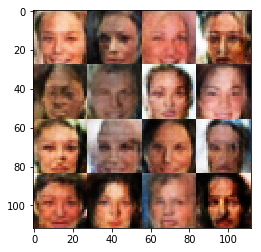

Discriminator Loss: 1.4423... Generator Loss: 0.8461
Discriminator Loss: 1.3245... Generator Loss: 0.7545
Discriminator Loss: 1.2204... Generator Loss: 0.8083
Discriminator Loss: 1.3918... Generator Loss: 0.8593
Discriminator Loss: 1.3397... Generator Loss: 0.6657
Discriminator Loss: 1.3069... Generator Loss: 0.7041
Discriminator Loss: 1.2942... Generator Loss: 1.1043
Discriminator Loss: 1.3127... Generator Loss: 0.7968
Discriminator Loss: 1.3399... Generator Loss: 0.6215
Discriminator Loss: 1.2835... Generator Loss: 0.9142
Discriminator Loss: 1.3980... Generator Loss: 0.6756
Discriminator Loss: 1.2186... Generator Loss: 0.8179
Discriminator Loss: 1.2825... Generator Loss: 0.8724
Discriminator Loss: 1.3119... Generator Loss: 0.7763
Discriminator Loss: 1.4501... Generator Loss: 0.6044
Discriminator Loss: 1.2428... Generator Loss: 1.1552
Discriminator Loss: 1.3259... Generator Loss: 0.7228
Discriminator Loss: 1.2523... Generator Loss: 0.7201
Discriminator Loss: 0.9857... Generator Loss: 

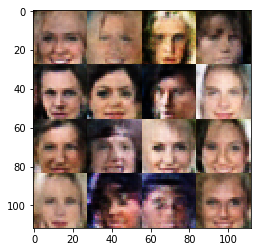

Discriminator Loss: 1.2351... Generator Loss: 0.7961
Discriminator Loss: 1.3576... Generator Loss: 0.9461
Discriminator Loss: 1.4551... Generator Loss: 0.6459
Discriminator Loss: 1.3295... Generator Loss: 0.7438
Discriminator Loss: 1.3872... Generator Loss: 0.8479
Discriminator Loss: 1.3318... Generator Loss: 0.6657
Discriminator Loss: 1.2172... Generator Loss: 0.8333
Discriminator Loss: 1.2623... Generator Loss: 0.8843
Discriminator Loss: 1.4284... Generator Loss: 0.6039
Discriminator Loss: 1.3391... Generator Loss: 0.7865
Discriminator Loss: 1.3656... Generator Loss: 0.7023
Discriminator Loss: 1.3765... Generator Loss: 0.7148
Discriminator Loss: 1.4173... Generator Loss: 0.7002
Discriminator Loss: 1.1614... Generator Loss: 0.9151
Discriminator Loss: 1.3243... Generator Loss: 0.7333
Discriminator Loss: 1.1872... Generator Loss: 0.8781
Discriminator Loss: 1.1261... Generator Loss: 1.0528
Discriminator Loss: 1.2600... Generator Loss: 0.8107
Discriminator Loss: 1.3470... Generator Loss: 

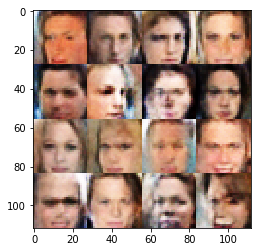

Discriminator Loss: 1.5062... Generator Loss: 0.6023
Discriminator Loss: 1.1786... Generator Loss: 0.9268
Discriminator Loss: 1.3746... Generator Loss: 0.6813
Discriminator Loss: 1.4561... Generator Loss: 0.6879
Discriminator Loss: 1.3301... Generator Loss: 0.6962
Discriminator Loss: 1.3393... Generator Loss: 0.8257
Discriminator Loss: 1.3010... Generator Loss: 0.6873
Discriminator Loss: 1.3519... Generator Loss: 0.6885
Discriminator Loss: 1.1749... Generator Loss: 0.9290
Discriminator Loss: 1.2669... Generator Loss: 0.7885
Discriminator Loss: 1.2287... Generator Loss: 0.8445
Discriminator Loss: 1.2626... Generator Loss: 0.7053
Discriminator Loss: 1.3203... Generator Loss: 0.8741
Discriminator Loss: 1.4190... Generator Loss: 0.6705
Discriminator Loss: 1.3781... Generator Loss: 0.6513
Discriminator Loss: 0.9808... Generator Loss: 1.3122
Discriminator Loss: 1.1974... Generator Loss: 0.8396
Discriminator Loss: 1.1999... Generator Loss: 0.8399
Discriminator Loss: 1.3415... Generator Loss: 

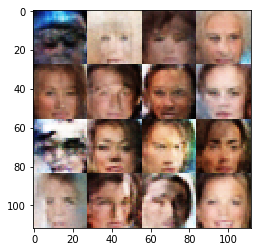

Discriminator Loss: 1.2276... Generator Loss: 0.9887
Discriminator Loss: 1.3369... Generator Loss: 0.6897
Discriminator Loss: 1.3727... Generator Loss: 0.6715
Discriminator Loss: 1.2509... Generator Loss: 0.8801
Discriminator Loss: 1.3293... Generator Loss: 0.7270
Discriminator Loss: 1.5511... Generator Loss: 0.6182
Discriminator Loss: 1.3088... Generator Loss: 0.7819
Discriminator Loss: 1.3449... Generator Loss: 0.6149
Discriminator Loss: 1.4605... Generator Loss: 0.8469
Discriminator Loss: 1.4261... Generator Loss: 0.6391
Discriminator Loss: 1.4604... Generator Loss: 0.6154
Discriminator Loss: 1.3787... Generator Loss: 0.8033
Discriminator Loss: 1.1023... Generator Loss: 0.9527
Discriminator Loss: 1.3769... Generator Loss: 0.6073
Discriminator Loss: 1.5706... Generator Loss: 0.5623
Discriminator Loss: 1.4073... Generator Loss: 0.9044
Discriminator Loss: 1.7362... Generator Loss: 0.4811
Discriminator Loss: 1.3486... Generator Loss: 0.6779
Discriminator Loss: 1.4944... Generator Loss: 

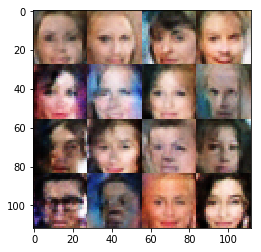

Discriminator Loss: 1.2854... Generator Loss: 0.8399
Discriminator Loss: 1.4480... Generator Loss: 0.5625
Discriminator Loss: 1.2541... Generator Loss: 1.1362
Discriminator Loss: 1.4636... Generator Loss: 0.6337
Discriminator Loss: 1.1996... Generator Loss: 0.7465
Discriminator Loss: 1.2921... Generator Loss: 0.7743
Discriminator Loss: 1.4203... Generator Loss: 0.7378
Discriminator Loss: 1.5003... Generator Loss: 0.6529
Discriminator Loss: 1.2079... Generator Loss: 0.8595
Discriminator Loss: 1.4763... Generator Loss: 0.6237
Discriminator Loss: 1.4732... Generator Loss: 0.6101
Discriminator Loss: 1.2307... Generator Loss: 1.0127
Discriminator Loss: 1.2785... Generator Loss: 0.6800
Discriminator Loss: 1.2627... Generator Loss: 0.7336
Discriminator Loss: 1.1766... Generator Loss: 0.9748
Discriminator Loss: 1.3449... Generator Loss: 0.6858
Discriminator Loss: 1.5217... Generator Loss: 0.5172
Discriminator Loss: 1.2098... Generator Loss: 0.8703
Discriminator Loss: 1.1542... Generator Loss: 

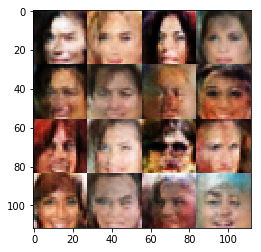

Discriminator Loss: 1.3097... Generator Loss: 0.8235
Discriminator Loss: 1.2691... Generator Loss: 0.8511
Discriminator Loss: 1.3213... Generator Loss: 0.7381
Discriminator Loss: 1.2248... Generator Loss: 0.7915
Discriminator Loss: 1.1119... Generator Loss: 1.3592
Discriminator Loss: 1.3193... Generator Loss: 0.6739
Discriminator Loss: 1.3056... Generator Loss: 0.7357
Discriminator Loss: 1.3299... Generator Loss: 1.0171
Discriminator Loss: 1.4219... Generator Loss: 0.5822
Discriminator Loss: 1.4450... Generator Loss: 0.7718
Discriminator Loss: 1.2530... Generator Loss: 0.7620
Discriminator Loss: 1.5590... Generator Loss: 0.4908
Discriminator Loss: 1.3562... Generator Loss: 0.9067
Discriminator Loss: 1.3173... Generator Loss: 0.7103
Discriminator Loss: 1.2351... Generator Loss: 0.8757
Discriminator Loss: 1.3498... Generator Loss: 0.7042
Discriminator Loss: 1.2601... Generator Loss: 0.7856
Discriminator Loss: 1.2421... Generator Loss: 1.0092
Discriminator Loss: 1.4470... Generator Loss: 

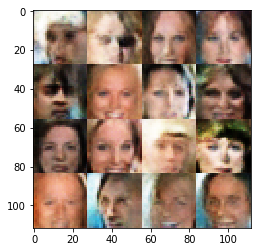

Discriminator Loss: 1.2461... Generator Loss: 0.7975
Discriminator Loss: 1.3228... Generator Loss: 1.1220
Discriminator Loss: 1.5017... Generator Loss: 0.5030
Discriminator Loss: 1.1770... Generator Loss: 1.0517
Discriminator Loss: 1.1081... Generator Loss: 0.9237
Discriminator Loss: 1.4405... Generator Loss: 0.6423
Discriminator Loss: 1.2636... Generator Loss: 0.8104
Discriminator Loss: 1.3797... Generator Loss: 0.6541
Discriminator Loss: 1.3003... Generator Loss: 0.6878
Discriminator Loss: 1.3854... Generator Loss: 0.7535
Discriminator Loss: 1.3614... Generator Loss: 0.6836
Discriminator Loss: 1.2361... Generator Loss: 0.9522
Discriminator Loss: 1.3554... Generator Loss: 0.7994
Discriminator Loss: 1.3509... Generator Loss: 0.6576
Discriminator Loss: 1.2032... Generator Loss: 1.0867
Discriminator Loss: 1.4123... Generator Loss: 0.6011
Discriminator Loss: 1.3461... Generator Loss: 0.8388
Discriminator Loss: 1.1999... Generator Loss: 0.8665
Discriminator Loss: 1.3196... Generator Loss: 

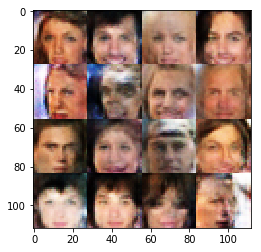

Discriminator Loss: 1.3839... Generator Loss: 0.6693
Discriminator Loss: 1.2941... Generator Loss: 0.9597
Discriminator Loss: 1.3913... Generator Loss: 0.6108
Discriminator Loss: 1.2402... Generator Loss: 0.8234
Discriminator Loss: 1.3931... Generator Loss: 0.6882
Discriminator Loss: 1.2734... Generator Loss: 0.7559
Discriminator Loss: 1.2303... Generator Loss: 0.8723
Discriminator Loss: 1.3974... Generator Loss: 0.6809
Discriminator Loss: 1.3895... Generator Loss: 0.6116
Discriminator Loss: 1.4081... Generator Loss: 0.6152
Discriminator Loss: 1.3598... Generator Loss: 0.8109
Discriminator Loss: 1.1885... Generator Loss: 0.9066
Discriminator Loss: 1.3032... Generator Loss: 0.6648
Discriminator Loss: 1.2571... Generator Loss: 0.8073
Discriminator Loss: 1.3439... Generator Loss: 0.6914
Discriminator Loss: 1.3134... Generator Loss: 0.7383
Discriminator Loss: 1.2283... Generator Loss: 0.7881
Discriminator Loss: 1.3921... Generator Loss: 0.6988
Discriminator Loss: 1.2889... Generator Loss: 

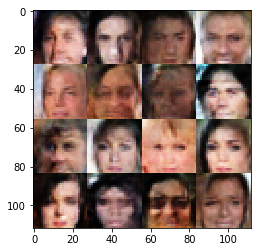

Discriminator Loss: 1.2391... Generator Loss: 0.7821
Discriminator Loss: 1.3806... Generator Loss: 0.7435
Discriminator Loss: 1.3673... Generator Loss: 0.7222
Discriminator Loss: 1.4020... Generator Loss: 0.6405
Discriminator Loss: 1.4244... Generator Loss: 0.6265
Discriminator Loss: 1.1579... Generator Loss: 1.0347
Discriminator Loss: 1.3883... Generator Loss: 0.6424
Discriminator Loss: 1.4007... Generator Loss: 0.6280
Discriminator Loss: 1.3074... Generator Loss: 0.7767
Discriminator Loss: 1.4136... Generator Loss: 0.6989
Discriminator Loss: 1.2847... Generator Loss: 0.7250
Discriminator Loss: 1.2894... Generator Loss: 0.9991
Discriminator Loss: 1.4267... Generator Loss: 0.5759
Discriminator Loss: 1.3048... Generator Loss: 0.8921
Discriminator Loss: 1.5441... Generator Loss: 0.5682
Discriminator Loss: 1.3589... Generator Loss: 0.7615
Discriminator Loss: 1.2144... Generator Loss: 0.8792
Discriminator Loss: 1.3314... Generator Loss: 0.7141
Discriminator Loss: 1.3651... Generator Loss: 

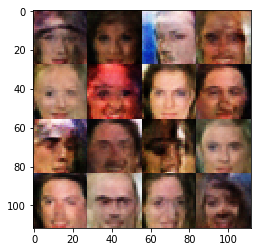

Discriminator Loss: 1.2075... Generator Loss: 1.0052
Discriminator Loss: 1.2039... Generator Loss: 0.7782
Discriminator Loss: 1.3000... Generator Loss: 0.8296
Discriminator Loss: 1.4499... Generator Loss: 0.6235
Discriminator Loss: 1.3074... Generator Loss: 0.9199
Discriminator Loss: 1.1529... Generator Loss: 0.9160
Discriminator Loss: 1.3091... Generator Loss: 0.6732
Discriminator Loss: 1.1609... Generator Loss: 1.2302
Discriminator Loss: 1.2869... Generator Loss: 0.6577
Discriminator Loss: 1.3071... Generator Loss: 0.7023
Discriminator Loss: 1.1742... Generator Loss: 0.9178
Discriminator Loss: 1.2644... Generator Loss: 0.8966
Discriminator Loss: 1.2842... Generator Loss: 0.6958
Discriminator Loss: 1.4686... Generator Loss: 0.5744
Discriminator Loss: 1.1574... Generator Loss: 1.0063
Discriminator Loss: 1.3850... Generator Loss: 0.6973
Discriminator Loss: 1.2792... Generator Loss: 0.7251
Discriminator Loss: 1.2968... Generator Loss: 1.0223
Discriminator Loss: 1.3824... Generator Loss: 

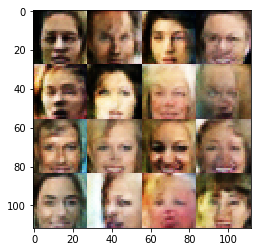

Discriminator Loss: 1.2796... Generator Loss: 1.3497
Discriminator Loss: 1.3388... Generator Loss: 0.6005
Discriminator Loss: 1.2001... Generator Loss: 0.9068
Discriminator Loss: 1.2308... Generator Loss: 0.7771
Discriminator Loss: 1.2541... Generator Loss: 0.8322
Discriminator Loss: 1.3817... Generator Loss: 0.7125
Discriminator Loss: 1.2169... Generator Loss: 0.9463
Discriminator Loss: 1.4318... Generator Loss: 0.5745
Discriminator Loss: 1.2128... Generator Loss: 0.7593
Discriminator Loss: 1.2600... Generator Loss: 1.0856
Discriminator Loss: 1.2834... Generator Loss: 0.7923
Discriminator Loss: 1.6529... Generator Loss: 0.4464
Discriminator Loss: 1.2635... Generator Loss: 1.0508
Discriminator Loss: 1.2250... Generator Loss: 0.8220
Discriminator Loss: 1.3405... Generator Loss: 0.7011
Discriminator Loss: 1.2526... Generator Loss: 0.9030
Discriminator Loss: 1.3759... Generator Loss: 0.6223
Discriminator Loss: 1.2572... Generator Loss: 0.8109
Discriminator Loss: 1.2252... Generator Loss: 

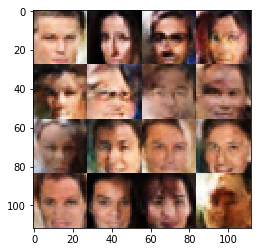

Discriminator Loss: 1.4005... Generator Loss: 0.6189
Discriminator Loss: 1.2696... Generator Loss: 0.8938
Discriminator Loss: 1.2730... Generator Loss: 0.9072
Discriminator Loss: 1.3951... Generator Loss: 0.5755
Discriminator Loss: 1.3030... Generator Loss: 0.9579
Discriminator Loss: 1.2991... Generator Loss: 0.6897
Discriminator Loss: 1.4715... Generator Loss: 0.6727
Discriminator Loss: 1.2967... Generator Loss: 0.8046
Discriminator Loss: 1.1065... Generator Loss: 1.0547
Discriminator Loss: 1.2534... Generator Loss: 0.7162
Discriminator Loss: 1.4460... Generator Loss: 0.6638
Discriminator Loss: 1.3985... Generator Loss: 0.6261
Discriminator Loss: 1.4211... Generator Loss: 0.7938
Discriminator Loss: 1.1966... Generator Loss: 0.7787
Discriminator Loss: 1.2186... Generator Loss: 0.7892
Discriminator Loss: 1.3299... Generator Loss: 0.8116
Discriminator Loss: 1.2779... Generator Loss: 0.6647
Discriminator Loss: 1.4793... Generator Loss: 0.6410
Discriminator Loss: 1.2492... Generator Loss: 

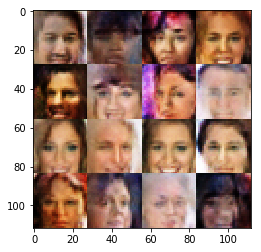

Discriminator Loss: 1.5117... Generator Loss: 0.7757
Discriminator Loss: 1.4103... Generator Loss: 0.5986
Discriminator Loss: 1.2732... Generator Loss: 0.7193
Discriminator Loss: 1.2062... Generator Loss: 0.9872
Discriminator Loss: 1.2564... Generator Loss: 0.7442
Discriminator Loss: 1.2394... Generator Loss: 0.7894
Discriminator Loss: 1.2213... Generator Loss: 0.8713
Discriminator Loss: 1.3266... Generator Loss: 0.7026
Discriminator Loss: 1.1600... Generator Loss: 0.9720
Discriminator Loss: 1.2929... Generator Loss: 0.6579
Discriminator Loss: 1.2512... Generator Loss: 0.9210
Discriminator Loss: 1.3215... Generator Loss: 0.7179
Discriminator Loss: 1.1008... Generator Loss: 1.1274
Discriminator Loss: 1.4469... Generator Loss: 0.5476
Discriminator Loss: 1.3098... Generator Loss: 0.9805
Discriminator Loss: 1.2391... Generator Loss: 0.8339
Discriminator Loss: 1.3594... Generator Loss: 0.5715
Discriminator Loss: 1.0942... Generator Loss: 1.1570
Discriminator Loss: 1.3672... Generator Loss: 

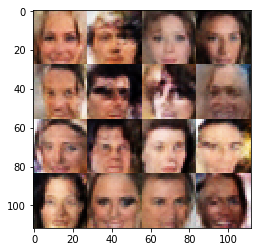

Discriminator Loss: 1.1977... Generator Loss: 0.9175
Discriminator Loss: 1.2409... Generator Loss: 0.7857
Discriminator Loss: 1.2162... Generator Loss: 0.9828
Discriminator Loss: 1.2705... Generator Loss: 0.6968
Discriminator Loss: 1.1630... Generator Loss: 0.9051
Discriminator Loss: 1.3222... Generator Loss: 0.7925
Discriminator Loss: 1.1231... Generator Loss: 0.8761
Discriminator Loss: 1.4868... Generator Loss: 0.7155
Discriminator Loss: 1.1896... Generator Loss: 0.8106
Discriminator Loss: 1.2096... Generator Loss: 0.7996
Discriminator Loss: 1.5091... Generator Loss: 0.6201
Discriminator Loss: 1.4128... Generator Loss: 0.6147
Discriminator Loss: 1.3353... Generator Loss: 0.7800
Discriminator Loss: 1.3052... Generator Loss: 0.9291
Discriminator Loss: 1.4287... Generator Loss: 0.5919
Discriminator Loss: 1.3239... Generator Loss: 0.8277
Discriminator Loss: 1.2474... Generator Loss: 0.8217
Discriminator Loss: 1.2179... Generator Loss: 0.8518
Discriminator Loss: 1.4804... Generator Loss: 

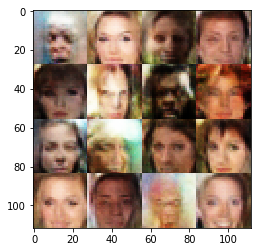

Discriminator Loss: 1.4581... Generator Loss: 0.9256
Discriminator Loss: 1.3188... Generator Loss: 0.8292
Discriminator Loss: 1.2950... Generator Loss: 0.7556
Discriminator Loss: 1.2179... Generator Loss: 0.8639
Discriminator Loss: 1.5740... Generator Loss: 0.4520
Discriminator Loss: 1.3113... Generator Loss: 0.8504
Discriminator Loss: 1.4045... Generator Loss: 0.6715
Discriminator Loss: 1.4926... Generator Loss: 0.5564
Discriminator Loss: 1.4027... Generator Loss: 0.8671
Discriminator Loss: 1.3386... Generator Loss: 0.8243
Discriminator Loss: 1.2496... Generator Loss: 0.6756
Discriminator Loss: 1.4021... Generator Loss: 0.5954
Discriminator Loss: 1.4106... Generator Loss: 1.0538
Discriminator Loss: 1.2393... Generator Loss: 0.9670
Discriminator Loss: 1.4282... Generator Loss: 0.5999
Discriminator Loss: 1.4069... Generator Loss: 0.7347
Discriminator Loss: 1.1786... Generator Loss: 0.9279
Discriminator Loss: 1.3028... Generator Loss: 0.7235
Discriminator Loss: 1.4194... Generator Loss: 

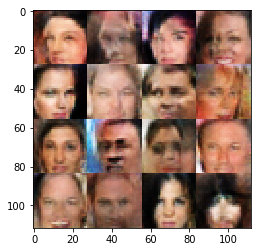

Discriminator Loss: 1.3381... Generator Loss: 0.6865
Discriminator Loss: 1.3014... Generator Loss: 1.0150
Discriminator Loss: 1.1631... Generator Loss: 0.8455
Discriminator Loss: 1.5418... Generator Loss: 0.4993
Discriminator Loss: 1.2119... Generator Loss: 1.1670
Discriminator Loss: 1.3660... Generator Loss: 0.6187
Discriminator Loss: 1.2549... Generator Loss: 0.7759
Discriminator Loss: 1.5610... Generator Loss: 0.5426
Discriminator Loss: 1.3043... Generator Loss: 0.7176
Discriminator Loss: 1.0984... Generator Loss: 0.9692
Discriminator Loss: 1.3340... Generator Loss: 0.6879
Discriminator Loss: 1.4090... Generator Loss: 0.6037
Discriminator Loss: 1.1419... Generator Loss: 1.0791
Discriminator Loss: 1.3539... Generator Loss: 0.6806
Discriminator Loss: 1.4887... Generator Loss: 0.5360
Discriminator Loss: 1.2421... Generator Loss: 0.8490
Discriminator Loss: 1.3415... Generator Loss: 0.8052
Discriminator Loss: 1.5004... Generator Loss: 0.5851
Discriminator Loss: 1.2210... Generator Loss: 

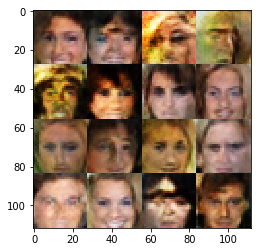

Discriminator Loss: 1.4745... Generator Loss: 0.5876
Discriminator Loss: 1.4399... Generator Loss: 0.7002
Discriminator Loss: 1.3810... Generator Loss: 0.6012
Discriminator Loss: 1.2861... Generator Loss: 0.9676
Discriminator Loss: 1.2217... Generator Loss: 0.7968
Discriminator Loss: 1.1968... Generator Loss: 0.8675
Discriminator Loss: 1.3902... Generator Loss: 0.7290
Discriminator Loss: 1.3917... Generator Loss: 0.8430
Discriminator Loss: 1.4353... Generator Loss: 0.5792
Discriminator Loss: 1.3864... Generator Loss: 0.6403
Discriminator Loss: 1.2167... Generator Loss: 0.9919
Discriminator Loss: 1.2109... Generator Loss: 0.8226
Discriminator Loss: 1.2330... Generator Loss: 0.7387
Discriminator Loss: 1.2897... Generator Loss: 0.9037
Discriminator Loss: 1.5406... Generator Loss: 0.5366
Discriminator Loss: 1.3015... Generator Loss: 0.7845
Discriminator Loss: 1.2283... Generator Loss: 0.8164
Discriminator Loss: 1.4090... Generator Loss: 0.6539
Discriminator Loss: 1.2195... Generator Loss: 

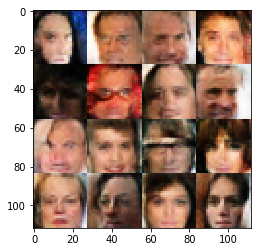

Discriminator Loss: 1.2456... Generator Loss: 1.0028
Discriminator Loss: 1.1977... Generator Loss: 0.8180
Discriminator Loss: 1.4406... Generator Loss: 0.5280
Discriminator Loss: 1.2627... Generator Loss: 1.2441
Discriminator Loss: 1.2375... Generator Loss: 0.7929
Discriminator Loss: 1.3741... Generator Loss: 0.6355
Discriminator Loss: 1.1731... Generator Loss: 0.9373
Discriminator Loss: 1.2590... Generator Loss: 0.7915
Discriminator Loss: 1.1724... Generator Loss: 1.1161
Discriminator Loss: 1.2184... Generator Loss: 0.7825
Discriminator Loss: 1.1638... Generator Loss: 0.8060
Discriminator Loss: 1.2679... Generator Loss: 0.7405
Discriminator Loss: 1.0831... Generator Loss: 1.0527
Discriminator Loss: 1.2840... Generator Loss: 0.6848
Discriminator Loss: 1.4091... Generator Loss: 0.7077
Discriminator Loss: 1.3005... Generator Loss: 0.7157
Discriminator Loss: 1.2523... Generator Loss: 0.8128
Discriminator Loss: 1.4310... Generator Loss: 0.6685
Discriminator Loss: 1.2022... Generator Loss: 

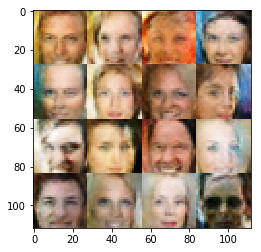

Discriminator Loss: 1.3826... Generator Loss: 0.6254
Discriminator Loss: 1.2906... Generator Loss: 0.7459
Discriminator Loss: 1.2288... Generator Loss: 0.8587
Discriminator Loss: 1.4982... Generator Loss: 0.5456
Discriminator Loss: 1.2650... Generator Loss: 0.9203
Discriminator Loss: 1.4940... Generator Loss: 0.5307
Discriminator Loss: 1.2710... Generator Loss: 0.9139
Discriminator Loss: 1.3265... Generator Loss: 0.6807
Discriminator Loss: 1.2555... Generator Loss: 0.9904
Discriminator Loss: 1.3909... Generator Loss: 0.7380
Discriminator Loss: 1.3335... Generator Loss: 0.6363
Discriminator Loss: 1.1141... Generator Loss: 1.1298
Discriminator Loss: 1.3430... Generator Loss: 0.6258
Discriminator Loss: 1.3487... Generator Loss: 0.8940
Discriminator Loss: 1.4850... Generator Loss: 0.5411
Discriminator Loss: 1.3285... Generator Loss: 0.8054
Discriminator Loss: 1.3592... Generator Loss: 0.6070
Discriminator Loss: 1.2794... Generator Loss: 0.9837
Discriminator Loss: 1.3742... Generator Loss: 

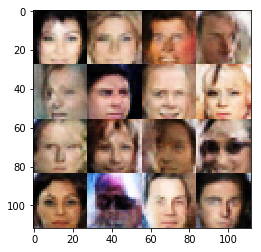

Discriminator Loss: 1.3345... Generator Loss: 0.7494
Discriminator Loss: 1.1814... Generator Loss: 1.0718
Discriminator Loss: 1.3655... Generator Loss: 0.6093
Discriminator Loss: 1.3154... Generator Loss: 0.7763
Discriminator Loss: 1.5139... Generator Loss: 0.5599
Discriminator Loss: 1.2140... Generator Loss: 0.7841
Discriminator Loss: 1.3591... Generator Loss: 0.7579
Discriminator Loss: 1.1912... Generator Loss: 0.8068
Discriminator Loss: 1.4801... Generator Loss: 0.6470
Discriminator Loss: 1.2975... Generator Loss: 0.6905
Discriminator Loss: 1.3212... Generator Loss: 1.0798
Discriminator Loss: 1.3675... Generator Loss: 0.6108
Discriminator Loss: 1.2030... Generator Loss: 1.0624
Discriminator Loss: 1.3666... Generator Loss: 0.6058
Discriminator Loss: 1.3524... Generator Loss: 0.6572
Discriminator Loss: 1.5120... Generator Loss: 0.9769
Discriminator Loss: 1.5279... Generator Loss: 0.5301
Discriminator Loss: 1.4860... Generator Loss: 0.7328
Discriminator Loss: 1.3448... Generator Loss: 

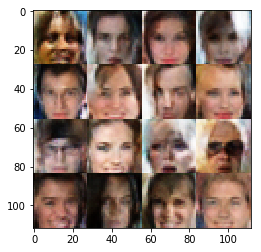

Discriminator Loss: 1.3559... Generator Loss: 0.8348
Discriminator Loss: 1.4175... Generator Loss: 0.6798
Discriminator Loss: 1.2675... Generator Loss: 0.6913
Discriminator Loss: 1.3190... Generator Loss: 0.8101
Discriminator Loss: 1.2350... Generator Loss: 0.8193
Discriminator Loss: 1.3968... Generator Loss: 0.5792
Discriminator Loss: 1.2949... Generator Loss: 0.8653
Discriminator Loss: 1.3773... Generator Loss: 0.5776
Discriminator Loss: 1.2971... Generator Loss: 0.7977
Discriminator Loss: 1.3016... Generator Loss: 0.9098
Discriminator Loss: 1.2963... Generator Loss: 0.6567
Discriminator Loss: 1.3938... Generator Loss: 0.5775
Discriminator Loss: 1.2594... Generator Loss: 0.7947
Discriminator Loss: 1.2851... Generator Loss: 0.8533
Discriminator Loss: 1.3533... Generator Loss: 0.6876
Discriminator Loss: 1.4734... Generator Loss: 0.5754
Discriminator Loss: 1.0631... Generator Loss: 1.0430
Discriminator Loss: 1.1582... Generator Loss: 0.9015
Discriminator Loss: 1.5143... Generator Loss: 

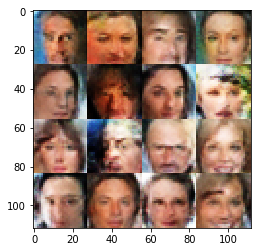

Discriminator Loss: 1.3002... Generator Loss: 0.6541
Discriminator Loss: 1.3121... Generator Loss: 0.8925
Discriminator Loss: 1.3464... Generator Loss: 0.6961
Discriminator Loss: 1.3349... Generator Loss: 0.7013
Discriminator Loss: 1.3949... Generator Loss: 0.6581
Discriminator Loss: 1.0772... Generator Loss: 1.0950
Discriminator Loss: 1.3562... Generator Loss: 0.6938
Discriminator Loss: 1.3929... Generator Loss: 0.6565
Discriminator Loss: 1.3882... Generator Loss: 0.6694
Discriminator Loss: 1.0907... Generator Loss: 0.9140
Discriminator Loss: 1.3103... Generator Loss: 0.7139
Discriminator Loss: 1.3718... Generator Loss: 0.6804
Discriminator Loss: 1.2453... Generator Loss: 0.6893
Discriminator Loss: 1.2848... Generator Loss: 0.8228
Discriminator Loss: 1.0829... Generator Loss: 1.2378
Discriminator Loss: 1.3817... Generator Loss: 0.5955
Discriminator Loss: 1.3486... Generator Loss: 0.6861
Discriminator Loss: 1.2342... Generator Loss: 0.8713
Discriminator Loss: 1.3626... Generator Loss: 

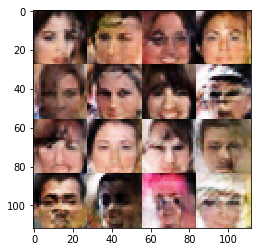

Discriminator Loss: 1.5498... Generator Loss: 0.5743
Discriminator Loss: 1.2992... Generator Loss: 0.7918
Discriminator Loss: 1.2338... Generator Loss: 0.9167
Discriminator Loss: 1.5592... Generator Loss: 0.5137
Discriminator Loss: 1.2677... Generator Loss: 0.8242
Discriminator Loss: 1.2877... Generator Loss: 0.8020
Discriminator Loss: 1.3534... Generator Loss: 0.6386
Discriminator Loss: 1.2685... Generator Loss: 0.8863
Discriminator Loss: 1.2062... Generator Loss: 0.9001
Discriminator Loss: 1.2843... Generator Loss: 0.9160
Discriminator Loss: 1.2592... Generator Loss: 0.7203
Discriminator Loss: 1.3631... Generator Loss: 0.6603
Discriminator Loss: 1.2374... Generator Loss: 0.9718
Discriminator Loss: 1.2218... Generator Loss: 0.8033
Discriminator Loss: 1.1920... Generator Loss: 0.7884
Discriminator Loss: 1.3367... Generator Loss: 0.7251
Discriminator Loss: 1.4548... Generator Loss: 0.6763
Discriminator Loss: 1.4260... Generator Loss: 0.6535
Discriminator Loss: 1.2987... Generator Loss: 

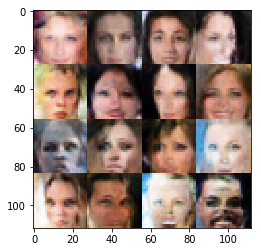

Discriminator Loss: 1.3997... Generator Loss: 0.6755
Discriminator Loss: 1.4318... Generator Loss: 0.5857
Discriminator Loss: 1.5338... Generator Loss: 0.5277
Discriminator Loss: 1.3329... Generator Loss: 0.7069
Discriminator Loss: 1.2941... Generator Loss: 0.8632
Discriminator Loss: 1.3793... Generator Loss: 0.6014
Discriminator Loss: 1.2070... Generator Loss: 0.8960
Discriminator Loss: 1.2308... Generator Loss: 0.9502
Discriminator Loss: 1.2840... Generator Loss: 0.7457
Discriminator Loss: 1.4304... Generator Loss: 0.5721
Discriminator Loss: 1.3255... Generator Loss: 1.2755
Discriminator Loss: 1.3310... Generator Loss: 0.6126
Discriminator Loss: 1.4960... Generator Loss: 0.5278
Discriminator Loss: 1.2655... Generator Loss: 1.1441
Discriminator Loss: 1.3999... Generator Loss: 0.6401
Discriminator Loss: 1.4285... Generator Loss: 0.5914
Discriminator Loss: 1.1342... Generator Loss: 1.0324
Discriminator Loss: 1.5159... Generator Loss: 0.4959
Discriminator Loss: 1.2590... Generator Loss: 

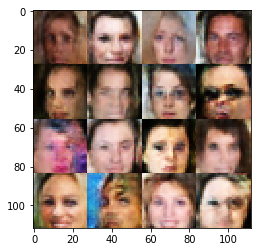

Discriminator Loss: 1.3410... Generator Loss: 0.7514
Discriminator Loss: 1.4116... Generator Loss: 0.5887
Discriminator Loss: 1.4251... Generator Loss: 0.6179
Discriminator Loss: 1.2656... Generator Loss: 0.7670
Discriminator Loss: 1.3722... Generator Loss: 0.5962
Discriminator Loss: 1.2458... Generator Loss: 1.2924
Discriminator Loss: 1.3748... Generator Loss: 0.5774
Discriminator Loss: 1.4003... Generator Loss: 0.6182
Discriminator Loss: 1.3310... Generator Loss: 0.7826
Discriminator Loss: 1.3498... Generator Loss: 0.7932
Discriminator Loss: 1.3139... Generator Loss: 0.6823
Discriminator Loss: 1.3432... Generator Loss: 0.8469
Discriminator Loss: 1.2161... Generator Loss: 0.7865
Discriminator Loss: 1.2810... Generator Loss: 0.7653
Discriminator Loss: 1.1790... Generator Loss: 1.0825
Discriminator Loss: 1.3062... Generator Loss: 0.6414
Discriminator Loss: 1.2835... Generator Loss: 0.8315
Discriminator Loss: 1.1476... Generator Loss: 1.0185
Discriminator Loss: 1.4404... Generator Loss: 

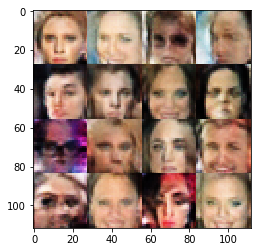

Discriminator Loss: 1.3388... Generator Loss: 0.7425
Discriminator Loss: 1.3732... Generator Loss: 0.7205
Discriminator Loss: 1.3459... Generator Loss: 0.6536
Discriminator Loss: 1.4510... Generator Loss: 0.7056
Discriminator Loss: 1.3005... Generator Loss: 0.7302
Discriminator Loss: 1.2536... Generator Loss: 0.7775
Discriminator Loss: 1.4654... Generator Loss: 0.6710
Discriminator Loss: 1.2364... Generator Loss: 1.0844
Discriminator Loss: 1.3083... Generator Loss: 0.6230
Discriminator Loss: 1.1819... Generator Loss: 0.8869
Discriminator Loss: 1.3467... Generator Loss: 0.6258
Discriminator Loss: 1.4115... Generator Loss: 0.5971
Discriminator Loss: 1.4174... Generator Loss: 1.0789
Discriminator Loss: 1.5235... Generator Loss: 0.5377
Discriminator Loss: 1.2420... Generator Loss: 0.8105
Discriminator Loss: 1.1065... Generator Loss: 1.1400
Discriminator Loss: 1.3834... Generator Loss: 0.5829
Discriminator Loss: 1.2045... Generator Loss: 0.9398
Discriminator Loss: 1.3603... Generator Loss: 

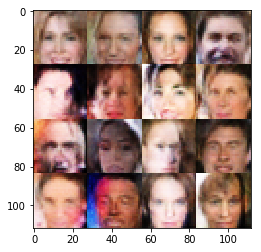

Discriminator Loss: 1.2829... Generator Loss: 0.6481
Discriminator Loss: 1.6238... Generator Loss: 0.4271
Discriminator Loss: 1.3485... Generator Loss: 0.8901
Discriminator Loss: 1.2746... Generator Loss: 0.8199
Discriminator Loss: 1.5595... Generator Loss: 0.4515
Discriminator Loss: 1.2558... Generator Loss: 1.2034
Discriminator Loss: 1.3168... Generator Loss: 0.6796
Discriminator Loss: 1.2046... Generator Loss: 0.7976
Discriminator Loss: 1.3803... Generator Loss: 0.7491
Discriminator Loss: 1.1983... Generator Loss: 0.8340
Discriminator Loss: 1.3382... Generator Loss: 0.6198
Discriminator Loss: 1.3498... Generator Loss: 0.8327
Discriminator Loss: 1.5997... Generator Loss: 0.4828
Discriminator Loss: 1.2719... Generator Loss: 0.7549
Discriminator Loss: 1.4357... Generator Loss: 0.6776
Discriminator Loss: 1.2141... Generator Loss: 0.8201
Discriminator Loss: 1.3683... Generator Loss: 0.6940
Discriminator Loss: 1.1503... Generator Loss: 0.8987
Discriminator Loss: 1.4261... Generator Loss: 

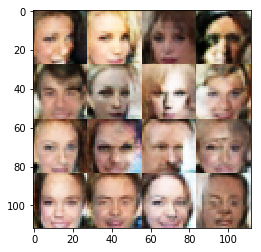

Discriminator Loss: 1.4551... Generator Loss: 0.5788
Discriminator Loss: 1.2684... Generator Loss: 0.9512
Discriminator Loss: 1.4810... Generator Loss: 0.6323
Discriminator Loss: 1.2409... Generator Loss: 0.6872
Discriminator Loss: 1.3195... Generator Loss: 0.8234
Discriminator Loss: 1.1403... Generator Loss: 1.0241
Discriminator Loss: 1.3278... Generator Loss: 0.6137
Discriminator Loss: 1.4994... Generator Loss: 0.5183
Discriminator Loss: 1.4877... Generator Loss: 0.7777
Discriminator Loss: 1.3018... Generator Loss: 0.7232
Discriminator Loss: 1.3326... Generator Loss: 0.6266
Discriminator Loss: 1.3176... Generator Loss: 0.8947
Discriminator Loss: 1.3004... Generator Loss: 0.6358
Discriminator Loss: 1.5844... Generator Loss: 0.4682
Discriminator Loss: 1.4191... Generator Loss: 0.6588
Discriminator Loss: 1.2776... Generator Loss: 0.7352
Discriminator Loss: 1.4932... Generator Loss: 0.5388
Discriminator Loss: 1.3512... Generator Loss: 0.8155
Discriminator Loss: 1.1941... Generator Loss: 

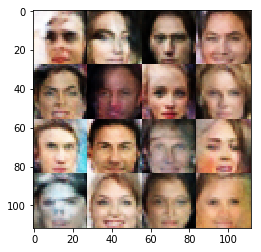

Discriminator Loss: 1.4821... Generator Loss: 0.5276
Discriminator Loss: 1.3994... Generator Loss: 0.6634
Discriminator Loss: 1.2732... Generator Loss: 0.9110
Discriminator Loss: 1.4939... Generator Loss: 0.5428
Discriminator Loss: 1.3774... Generator Loss: 0.6302
Discriminator Loss: 1.3635... Generator Loss: 0.7015
Discriminator Loss: 1.2625... Generator Loss: 0.7167
Discriminator Loss: 1.3327... Generator Loss: 0.7884
Discriminator Loss: 1.4232... Generator Loss: 0.6301
Discriminator Loss: 1.2559... Generator Loss: 0.7676
Discriminator Loss: 1.3745... Generator Loss: 0.8194
Discriminator Loss: 1.5789... Generator Loss: 0.5453
Discriminator Loss: 1.2693... Generator Loss: 0.9193
Discriminator Loss: 1.4093... Generator Loss: 0.5891
Discriminator Loss: 1.4584... Generator Loss: 0.6144
Discriminator Loss: 1.2753... Generator Loss: 0.7467
Discriminator Loss: 1.1307... Generator Loss: 1.1159
Discriminator Loss: 1.4753... Generator Loss: 0.5356
Discriminator Loss: 1.2947... Generator Loss: 

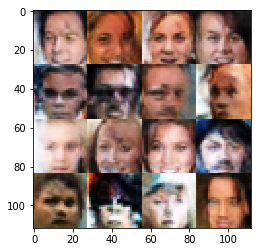

Discriminator Loss: 1.2881... Generator Loss: 0.6960
Discriminator Loss: 1.2745... Generator Loss: 0.8018
Discriminator Loss: 1.1805... Generator Loss: 0.8282
Discriminator Loss: 1.2876... Generator Loss: 0.8301
Discriminator Loss: 1.3831... Generator Loss: 0.6559
Discriminator Loss: 1.1922... Generator Loss: 0.9430
Discriminator Loss: 1.3555... Generator Loss: 0.6821
Discriminator Loss: 1.4011... Generator Loss: 0.5866
Discriminator Loss: 1.1899... Generator Loss: 0.9514
Discriminator Loss: 1.1686... Generator Loss: 0.9502
Discriminator Loss: 1.4508... Generator Loss: 0.5271
Discriminator Loss: 1.4849... Generator Loss: 0.6484
Discriminator Loss: 1.3274... Generator Loss: 0.6661
Discriminator Loss: 1.3003... Generator Loss: 0.8935
Discriminator Loss: 1.1214... Generator Loss: 0.9623
Discriminator Loss: 1.5816... Generator Loss: 0.4444
Discriminator Loss: 1.3198... Generator Loss: 0.8334
Discriminator Loss: 1.2550... Generator Loss: 0.8524
Discriminator Loss: 1.5395... Generator Loss: 

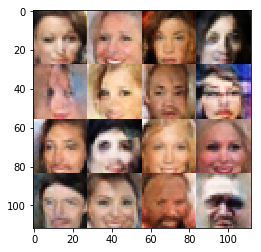

Discriminator Loss: 1.4561... Generator Loss: 0.5865
Discriminator Loss: 1.1632... Generator Loss: 0.9632
Discriminator Loss: 1.6213... Generator Loss: 0.4184
Discriminator Loss: 1.4025... Generator Loss: 0.6055
Discriminator Loss: 1.2318... Generator Loss: 1.0110
Discriminator Loss: 1.6196... Generator Loss: 0.4538
Discriminator Loss: 1.4594... Generator Loss: 0.6572
Discriminator Loss: 1.3032... Generator Loss: 0.7920
Discriminator Loss: 1.4731... Generator Loss: 0.5449
Discriminator Loss: 1.4659... Generator Loss: 0.5759
Discriminator Loss: 1.2537... Generator Loss: 0.9950
Discriminator Loss: 1.2609... Generator Loss: 0.7058
Discriminator Loss: 1.3278... Generator Loss: 0.5922
Discriminator Loss: 1.3259... Generator Loss: 0.7510
Discriminator Loss: 1.3109... Generator Loss: 0.8890
Discriminator Loss: 1.5295... Generator Loss: 0.5107
Discriminator Loss: 1.5202... Generator Loss: 0.4811
Discriminator Loss: 1.2875... Generator Loss: 0.8317
Discriminator Loss: 1.2478... Generator Loss: 

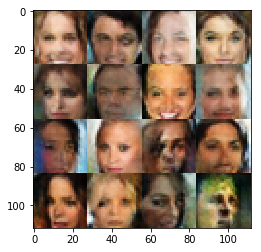

Discriminator Loss: 1.1671... Generator Loss: 1.1805
Discriminator Loss: 1.1389... Generator Loss: 0.7918
Discriminator Loss: 1.4253... Generator Loss: 0.6026
Discriminator Loss: 1.3513... Generator Loss: 0.6721
Discriminator Loss: 1.3292... Generator Loss: 0.6634
Discriminator Loss: 1.2854... Generator Loss: 0.7616
Discriminator Loss: 1.4576... Generator Loss: 0.6297
Discriminator Loss: 1.2658... Generator Loss: 0.7923
Discriminator Loss: 1.4012... Generator Loss: 0.5802
Discriminator Loss: 1.2889... Generator Loss: 0.8807
Discriminator Loss: 1.3735... Generator Loss: 0.6724
Discriminator Loss: 1.2662... Generator Loss: 0.6719
Discriminator Loss: 1.0853... Generator Loss: 1.0587
Discriminator Loss: 1.4343... Generator Loss: 0.6376
Discriminator Loss: 1.2853... Generator Loss: 0.7196
Discriminator Loss: 1.2801... Generator Loss: 1.1488
Discriminator Loss: 1.3185... Generator Loss: 0.6033
Discriminator Loss: 1.1393... Generator Loss: 1.0673
Discriminator Loss: 1.2483... Generator Loss: 

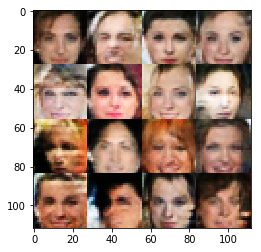

Discriminator Loss: 1.4127... Generator Loss: 0.6916
Discriminator Loss: 1.3533... Generator Loss: 0.6198
Discriminator Loss: 1.4310... Generator Loss: 0.6805
Discriminator Loss: 1.1774... Generator Loss: 0.9135
Discriminator Loss: 1.3893... Generator Loss: 0.6884
Discriminator Loss: 1.3253... Generator Loss: 0.6788
Discriminator Loss: 1.3507... Generator Loss: 0.7926
Discriminator Loss: 1.1294... Generator Loss: 0.9386
Discriminator Loss: 1.3275... Generator Loss: 0.5906
Discriminator Loss: 1.1072... Generator Loss: 1.1049
Discriminator Loss: 1.1248... Generator Loss: 0.9088
Discriminator Loss: 1.5330... Generator Loss: 0.4600
Discriminator Loss: 1.2322... Generator Loss: 1.2921
Discriminator Loss: 1.1840... Generator Loss: 0.7842
Discriminator Loss: 1.0713... Generator Loss: 0.9288
Discriminator Loss: 1.5756... Generator Loss: 0.5214
Discriminator Loss: 1.0708... Generator Loss: 1.3810
Discriminator Loss: 1.5821... Generator Loss: 0.4399
Discriminator Loss: 1.4437... Generator Loss: 

In [42]:
#batch_size = 128
#z_dim = 100
#learning_rate = 0.0005
#beta1 =0.3

batch_size = 30
z_dim = 200
learning_rate = 0.0002
beta1 = 0.4

#batch_size = 48
#z_dim = 300
#learning_rate = 0.0002
#beta1 = 0.4

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.